In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import tifffile
import matplotlib.colors as mcolors
from skimage import io, measure, morphology
from scipy.ndimage import binary_dilation, generate_binary_structure
from scipy.spatial import distance
from skimage import io, color, measure
from skimage.util import img_as_float
from scipy.spatial import distance
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
import glob
import os

In [3]:
def load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path):
    fgf = io.imread(fgf_path)
    fgf_mask = io.imread(fgf_mask_path)
    psm_mask = io.imread(psm_mask_path)
    loi = io.imread(loi_path)
    dextran = io.imread(dextran_path)
    return fgf, fgf_mask, psm_mask, loi, dextran

def create_combined_mask(fgf_mask, psm_mask):
    return fgf_mask * psm_mask

def find_positive_pixels(fgf_psm_mask, fgf_image):
    positive_pixels = np.column_stack(np.where(fgf_psm_mask))
    intensities = fgf_image[positive_pixels[:, 0], positive_pixels[:, 1]]
    return positive_pixels, intensities

def calculate_nearest_loi_points(positive_pixels, loi_coords):
    nearest_loi_points = []
    for pixel in positive_pixels:
        distances = distance.cdist([pixel], loi_coords, metric='euclidean')
        nearest_loi_point = np.argmin(distances)
        nearest_loi_points.append(nearest_loi_point)
    return np.array(nearest_loi_points)

def calculate_intensity_profile(nearest_loi_points, intensities, loi_coords):
    intensity_profile = np.zeros(len(loi_coords))
    counts = np.zeros(len(loi_coords))
    for i, loi_point_index in enumerate(nearest_loi_points):
        intensity_profile[loi_point_index] += intensities[i]
        counts[loi_point_index] += 1
    intensity_profile = np.divide(intensity_profile, counts, out=np.zeros_like(intensity_profile), where=counts > 0)
    return intensity_profile

def plot_intensity_profile(positions, interpolated_intensities, save_path):
    plt.figure(figsize=(10, 5))
    plt.plot(positions, interpolated_intensities, c='b')
    plt.xlabel('Position along the PSM (a.u.)')
    plt.ylabel('Normalized FGF Intensity (a.u.)')
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def visualize_filtered_fgf(fgf_image, fgf_psm_binary, save_path):
    filtered_fgf = np.zeros_like(fgf_image)
    filtered_fgf[fgf_psm_binary] = fgf_image[fgf_psm_binary]
    
    plt.figure(figsize=(10, 5))
    plt.imshow(filtered_fgf, cmap='turbo', vmin=0, vmax=2500)
    plt.colorbar(label='FGF Intensity (Non Normalized)')
    plt.axis('off')
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def visualize_filtered_normalized_fgf(fgf_image, dextran_image, fgf_psm_binary, save_path):
    normalized_fgf = np.zeros_like(fgf_image, dtype=np.float64)
    non_zero_dextran = dextran_image[fgf_psm_binary] > 0
    normalized_fgf[fgf_psm_binary] = fgf_image[fgf_psm_binary].astype(np.float64) / np.where(dextran_image[fgf_psm_binary] > 0, dextran_image[fgf_psm_binary], 1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(normalized_fgf, cmap='turbo')
    plt.colorbar(label='FGF Intensity (Normalized)')
    plt.axis('off')
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_combined_binned_profiles(all_interp_positions, all_interp_values, save_path, num_timepoints):
    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.get_cmap('plasma')  
    norm = plt.Normalize(vmin=0, vmax=num_timepoints - 1) 

    for i, (interp_positions, interp_values) in enumerate(zip(all_interp_positions, all_interp_values)):
        color = cmap(norm(i))  
        ax.plot(interp_positions, interp_values, color=color)  

    ax.set_xlabel('Binned Position along the PSM (a.u.)')
    ax.set_ylabel('Normalized FGF Intensity (a.u.)')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)  
    cbar.set_label('Time') 
    cbar_ticks = np.linspace(0, num_timepoints - 1, 5).astype(int)  
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{i * 15} min" for i in cbar_ticks])  
    plt.savefig(save_path, format='tiff', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir):
    fgf_images = sorted(glob.glob(os.path.join(image_dir, '*.tif')))
    fgf_masks = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
    psm_masks = sorted(glob.glob(os.path.join(psm_dir, '*.tif')))
    lois = sorted(glob.glob(os.path.join(loi_dir, '*.tif')))
    dextran_images = sorted(glob.glob(os.path.join(dextran_dir, '*.tif')))
    
    if not (len(fgf_images) == len(fgf_masks) == len(psm_masks) == len(lois) == len(dextran_images)):
        raise ValueError("Not the same number of images")
    
    return fgf_images, fgf_masks, psm_masks, lois, dextran_images

In [4]:
def fgf_quantification_pipeline_multiple(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir):
    fgf_images, fgf_masks, psm_masks, lois, dextran_images = load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir)
    
    all_interp_positions = []
    all_interp_values = []

    for i, (fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path) in enumerate(zip(fgf_images, fgf_masks, psm_masks, lois, dextran_images)):
        print(f"Processing image set {i + 1}/{len(fgf_images)}")
        
        image_results_dir = os.path.join(results_dir, f"image_set_{i + 1}")
        os.makedirs(image_results_dir, exist_ok=True)

        interp_positions, interp_values = fgf_quantification_pipeline_with_euclidean(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, image_results_dir)

        all_interp_positions.append(interp_positions)
        all_interp_values.append(interp_values)

    combined_plot_path = os.path.join(results_dir, 'combined_binned_profiles.svg')
    plot_combined_binned_profiles(all_interp_positions, all_interp_values, combined_plot_path, num_timepoints=len(fgf_images))
    
    
    print(f"Processing complete. Results saved in {results_dir}")

def fgf_quantification_pipeline_with_euclidean(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, results_dir):
    fgf, fgf_mask, psm_mask, loi, dextran = load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path)
    fgf_psm_mask = create_combined_mask(fgf_mask, psm_mask)
    positive_pixels, fgf_intensities = find_positive_pixels(fgf_psm_mask, fgf)

    dextran_positive_pixels, dextran_intensities = find_positive_pixels(fgf_psm_mask, dextran)

    normalized_intensities = np.divide(fgf_intensities.astype(np.float64), dextran_intensities.astype(np.float64),
                                       out=np.zeros_like(fgf_intensities, dtype=np.float64), where=dextran_intensities > 0)

    loi_coords = np.column_stack(np.where(loi))
    nearest_loi_points = calculate_nearest_loi_points(positive_pixels, loi_coords)
    intensity_profile = calculate_intensity_profile(nearest_loi_points, normalized_intensities, loi_coords)

    rightmost_loi_point = loi_coords[np.argmax(loi_coords[:, 1])]
    distances_from_rightmost = distance.cdist([rightmost_loi_point], loi_coords, metric='euclidean').flatten()

    sorted_indices = np.argsort(distances_from_rightmost)
    sorted_distances = distances_from_rightmost[sorted_indices]
    sorted_intensity_profile = intensity_profile[sorted_indices]

    non_zero_mask = sorted_intensity_profile > 0
    interp_func = interp1d(sorted_distances[non_zero_mask], sorted_intensity_profile[non_zero_mask], bounds_error=False, fill_value="extrapolate")
    interpolated_intensities = interp_func(sorted_distances)

    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances, interpolated_intensities, c='b')
    plt.xlabel('Position along the PSM (a.u.)')
    plt.ylabel('Normalized FGF Intensity (a.u.)')
    plot_path = os.path.join(results_dir, 'intensity_profile_euclidean.svg')
    plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    filtered_fgf_image_path = os.path.join(results_dir, 'filtered_fgf_image_non_normalized.svg')
    fgf_psm_binary = fgf_psm_mask > 0
    visualize_filtered_fgf(fgf, fgf_psm_binary, filtered_fgf_image_path)

    filtered_fgf_image_normalized_path = os.path.join(results_dir, 'filtered_fgf_image_normalized.svg')
    visualize_filtered_normalized_fgf(fgf, dextran, fgf_psm_binary, filtered_fgf_image_normalized_path)

    num_bins = 50
    bin_edges = np.linspace(0, sorted_distances[-1], num_bins + 1)
    bin_indices = np.digitize(sorted_distances, bin_edges)

    binned_intensities = np.array([interpolated_intensities[bin_indices == i].mean() for i in range(1, num_bins + 1)])
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

    interp_bin_func = interp1d(bin_centers, binned_intensities, kind='linear', fill_value="extrapolate")
    interp_positions = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    interp_values = interp_bin_func(interp_positions)

    plt.figure(figsize=(10, 5))
    plt.plot(interp_positions, interp_values, c='b')
    plt.xlabel('Binned Position along the PSM (a.u.)')
    plt.ylabel('Normalized FGF Intensity (a.u.)')
    binned_plot_path = os.path.join(results_dir, 'binned_plot_euclidean.svg')
    plt.savefig(binned_plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return interp_positions, interp_values

In [ ]:
image_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E3/fgf'
mask_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E3/fgf_mask/'
psm_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E3/tissue/'
loi_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E3/loi/'
dextran_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E3/fgf/'
results_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E3/result'

fgf_quantification_pipeline_multiple(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir)

Processing image set 1/22


KeyboardInterrupt: 

In [10]:
#SINGLE CHANNEL QUANTIFICATION

def load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path):
    fgf = io.imread(fgf_path)
    fgf_mask = io.imread(fgf_mask_path)
    psm_mask = io.imread(psm_mask_path)
    loi = io.imread(loi_path)
    dextran = io.imread(dextran_path)
    return fgf, fgf_mask, psm_mask, loi, dextran

def create_combined_mask(fgf_mask, psm_mask):
    return fgf_mask * psm_mask

def find_positive_pixels(fgf_psm_mask, fgf_image):
    positive_pixels = np.column_stack(np.where(fgf_psm_mask))
    intensities = fgf_image[positive_pixels[:, 0], positive_pixels[:, 1]]
    return positive_pixels, intensities

def calculate_nearest_loi_points(positive_pixels, loi_coords):
    nearest_loi_points = []
    for pixel in positive_pixels:
        distances = distance.cdist([pixel], loi_coords, metric='euclidean')
        nearest_loi_point = np.argmin(distances)
        nearest_loi_points.append(nearest_loi_point)
    return np.array(nearest_loi_points)

def calculate_intensity_profile(nearest_loi_points, intensities, loi_coords):
    intensity_profile = np.zeros(len(loi_coords))
    counts = np.zeros(len(loi_coords))
    for i, loi_point_index in enumerate(nearest_loi_points):
        intensity_profile[loi_point_index] += intensities[i]
        counts[loi_point_index] += 1
    intensity_profile = np.divide(intensity_profile, counts, out=np.zeros_like(intensity_profile), where=counts > 0)
    return intensity_profile

def plot_intensity_profile(positions, interpolated_intensities, save_path):
    plt.figure(figsize=(10, 5))
    plt.plot(positions, interpolated_intensities, c='b')
    plt.xlabel('Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def visualize_filtered_fgf(fgf_image, fgf_psm_binary, save_path):
    filtered_fgf = np.zeros_like(fgf_image)
    filtered_fgf[fgf_psm_binary] = fgf_image[fgf_psm_binary]
    
    plt.figure(figsize=(10, 5))
    plt.imshow(filtered_fgf, cmap='turbo', vmin=0, vmax=2500)
    plt.colorbar(label='FGF Intensity (Non Normalized)')
    plt.axis('off')
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def visualize_filtered_normalized_fgf(fgf_image, dextran_image, fgf_psm_binary, save_path):
    normalized_fgf = np.zeros_like(fgf_image, dtype=np.float64)
    non_zero_dextran = dextran_image[fgf_psm_binary] > 0
    normalized_fgf[fgf_psm_binary] = fgf_image[fgf_psm_binary].astype(np.float64) / np.where(dextran_image[fgf_psm_binary] > 0, dextran_image[fgf_psm_binary], 1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(normalized_fgf, cmap='turbo')
    plt.colorbar(label='FGF Intensity (Normalized)')
    plt.axis('off')
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_combined_binned_profiles(all_interp_positions, all_interp_values, save_path, num_timepoints):
    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.get_cmap('tab20b')  
    norm = plt.Normalize(vmin=0, vmax=num_timepoints - 1) 

    for i, (interp_positions, interp_values) in enumerate(zip(all_interp_positions, all_interp_values)):
        color = cmap(norm(i))  
        ax.plot(interp_positions, interp_values, color=color)  

    ax.set_xlabel('Binned Position along the PSM (a.u.)')
    ax.set_ylabel('FGF Intensity (a.u.)')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)  
    cbar.set_label('Time') 
    cbar_ticks = np.linspace(0, num_timepoints - 1, 5).astype(int)  
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{i * 15} min" for i in cbar_ticks])  
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir):
    fgf_images = sorted(glob.glob(os.path.join(image_dir, '*.tif')))
    fgf_masks = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
    psm_masks = sorted(glob.glob(os.path.join(psm_dir, '*.tif')))
    lois = sorted(glob.glob(os.path.join(loi_dir, '*.tif')))
    dextran_images = sorted(glob.glob(os.path.join(dextran_dir, '*.tif')))
    
    if not (len(fgf_images) == len(fgf_masks) == len(psm_masks) == len(lois) == len(dextran_images)):
        raise ValueError("Not the same number of images")
    
    return fgf_images, fgf_masks, psm_masks, lois, dextran_images

def fgf_quantification_pipeline_multiple(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir):
    fgf_images, fgf_masks, psm_masks, lois, dextran_images = load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir)
    
    all_interp_positions = []
    all_interp_values = []

    for i, (fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path) in enumerate(zip(fgf_images, fgf_masks, psm_masks, lois, dextran_images)):
        print(f"Processing image set {i + 1}/{len(fgf_images)}")
        
        image_results_dir = os.path.join(results_dir, f"image_set_{i + 1}")
        os.makedirs(image_results_dir, exist_ok=True)

        interp_positions, interp_values = fgf_quantification_pipeline_with_euclidean_no_normalization(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, image_results_dir)

        all_interp_positions.append(interp_positions)
        all_interp_values.append(interp_values)

    combined_plot_path = os.path.join(results_dir, 'combined_binned_profiles.svg')
    plot_combined_binned_profiles(all_interp_positions, all_interp_values, combined_plot_path, num_timepoints=len(fgf_images))
    
    print(f"Processing complete. Results saved in {results_dir}")

def fgf_quantification_pipeline_with_euclidean_no_normalization(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, results_dir):
    fgf, fgf_mask, psm_mask, loi, _ = load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path)
    fgf_psm_mask = create_combined_mask(fgf_mask, psm_mask)
    positive_pixels, fgf_intensities = find_positive_pixels(fgf_psm_mask, fgf)

    normalized_intensities = fgf_intensities.astype(np.float64)  # Nessuna normalizzazione

    loi_coords = np.column_stack(np.where(loi))
    nearest_loi_points = calculate_nearest_loi_points(positive_pixels, loi_coords)
    intensity_profile = calculate_intensity_profile(nearest_loi_points, normalized_intensities, loi_coords)

    rightmost_loi_point = loi_coords[np.argmax(loi_coords[:, 1])]
    distances_from_rightmost = distance.cdist([rightmost_loi_point], loi_coords, metric='euclidean').flatten()

    sorted_indices = np.argsort(distances_from_rightmost)
    sorted_distances = distances_from_rightmost[sorted_indices]
    sorted_intensity_profile = intensity_profile[sorted_indices]

    non_zero_mask = sorted_intensity_profile > 0
    interp_func = interp1d(sorted_distances[non_zero_mask], sorted_intensity_profile[non_zero_mask], bounds_error=False, fill_value="extrapolate")
    interpolated_intensities = interp_func(sorted_distances)

    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances, interpolated_intensities, c='b')
    plt.xlabel('Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    plot_path = os.path.join(results_dir, 'intensity_profile_no_normalization.svg')
    plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    filtered_fgf_image_path = os.path.join(results_dir, 'filtered_fgf_image_non_normalized.tif')
    fgf_psm_binary = fgf_psm_mask > 0
    visualize_filtered_fgf(fgf, fgf_psm_binary, filtered_fgf_image_path)

    num_bins = 50
    bin_edges = np.linspace(0, sorted_distances[-1], num_bins + 1)
    bin_indices = np.digitize(sorted_distances, bin_edges)

    binned_intensities = np.array([interpolated_intensities[bin_indices == i].mean() for i in range(1, num_bins + 1)])
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

    interp_bin_func = interp1d(bin_centers, binned_intensities, kind='linear', fill_value="extrapolate")
    interp_positions = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    interp_values = interp_bin_func(interp_positions)

    plt.figure(figsize=(10, 5))
    plt.plot(interp_positions, interp_values, c='b')
    plt.xlabel('Binned Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    binned_plot_path = os.path.join(results_dir, 'binned_plot_no_normalization.svg')
    plt.savefig(binned_plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return interp_positions, interp_values

Processing image set 1/3


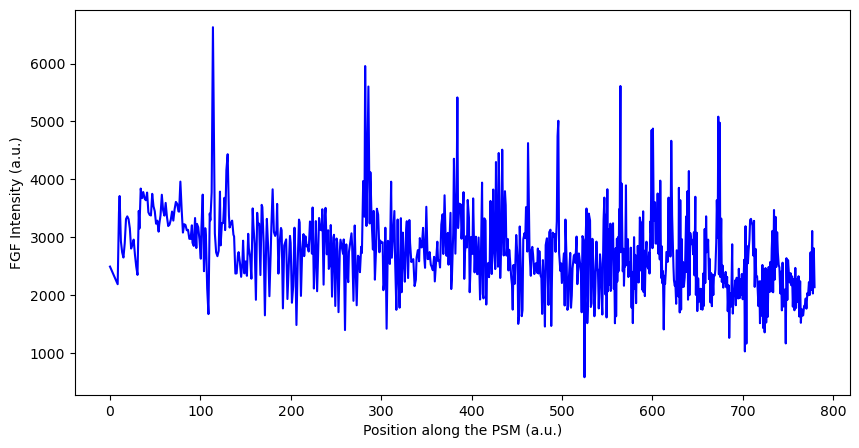

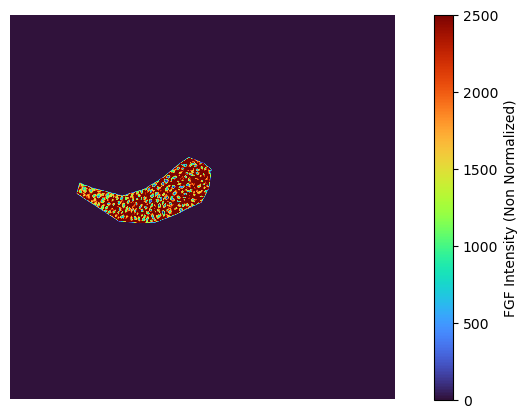

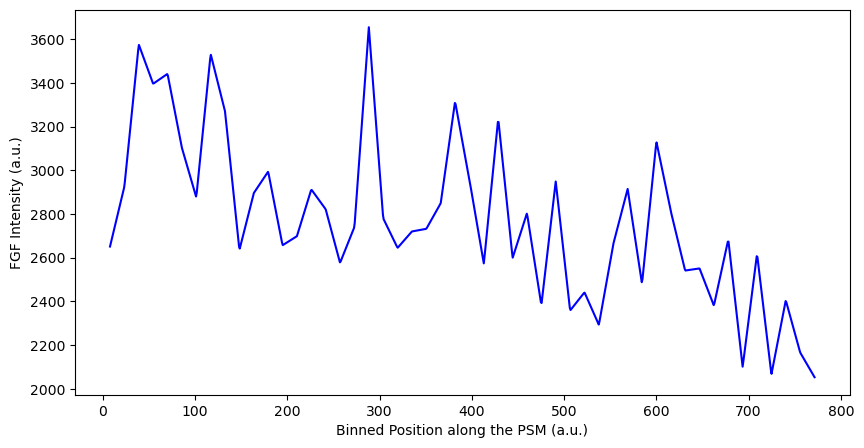

Processing image set 2/3


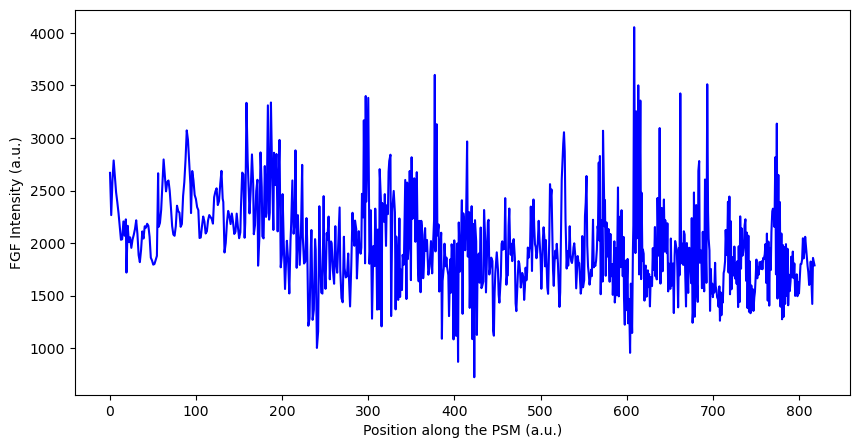

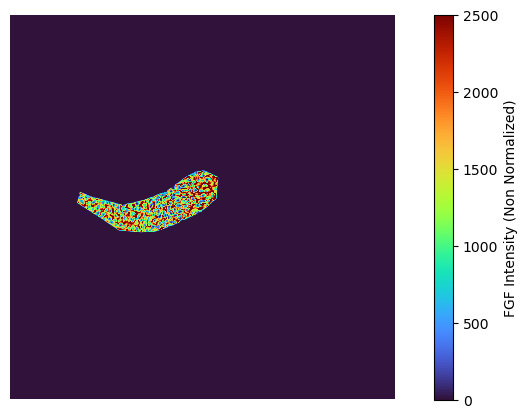

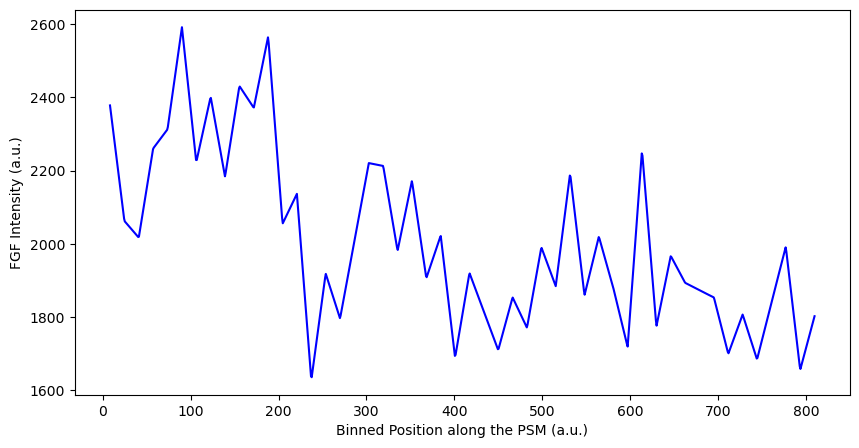

Processing image set 3/3


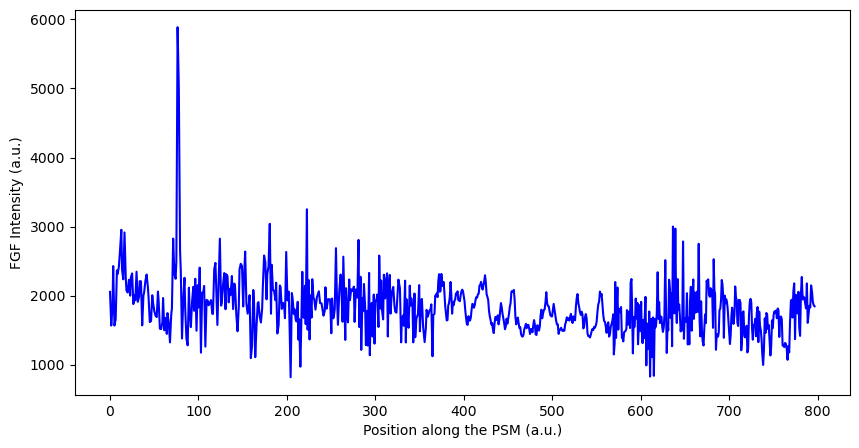

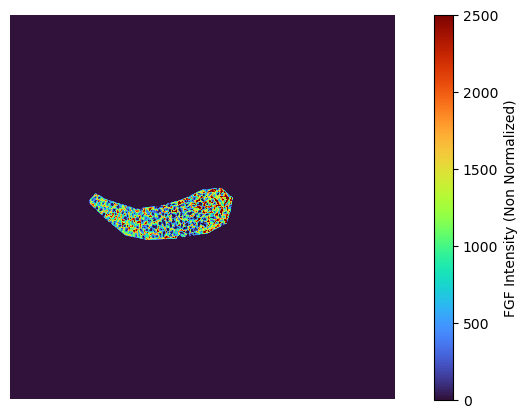

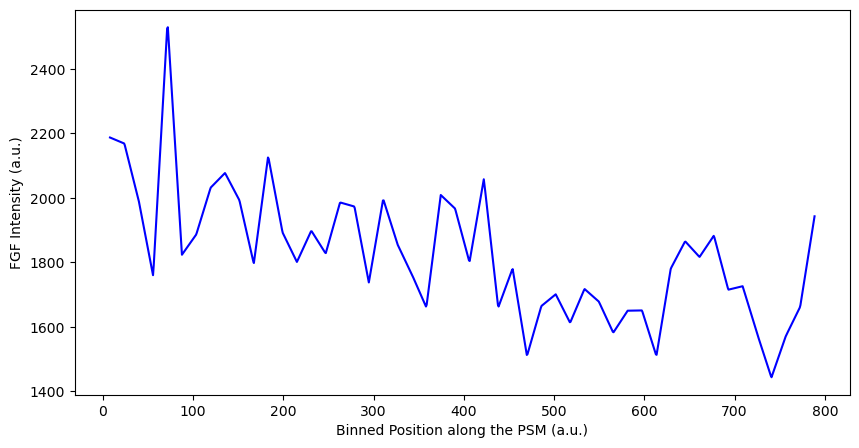

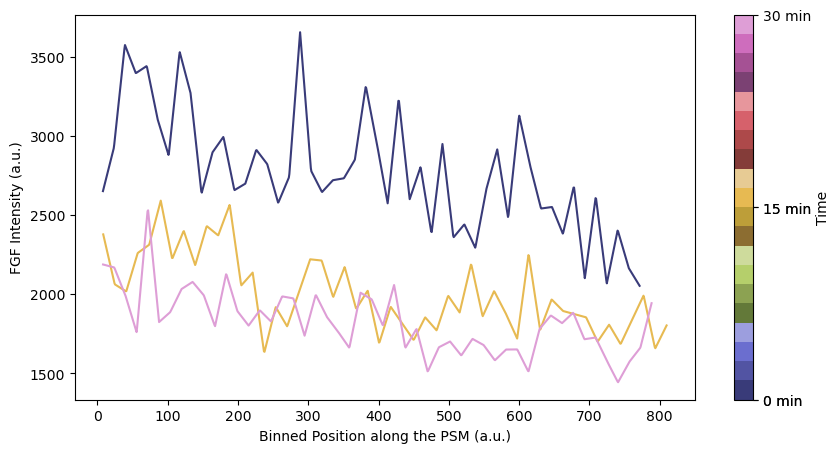

Processing complete. Results saved in E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/result


In [11]:
image_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/fgf'
mask_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/fgf_mask/'
psm_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/tissue/'
loi_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/loi/'
dextran_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/fgf/'
results_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/result'

fgf_quantification_pipeline_multiple(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir)

Processing image set 1/5


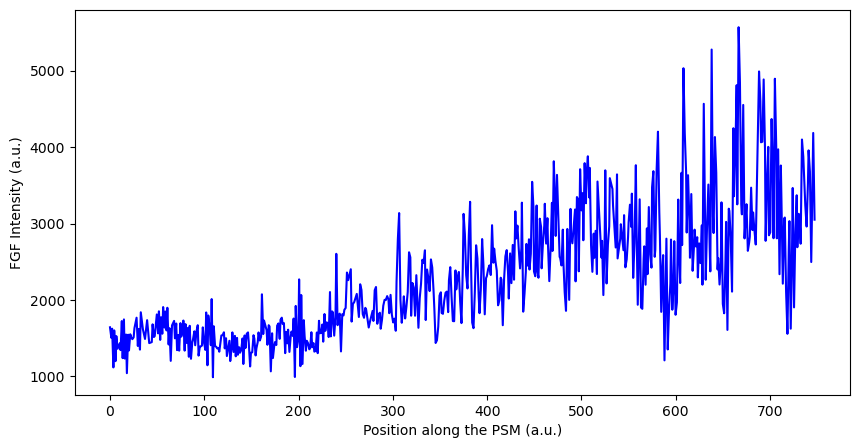

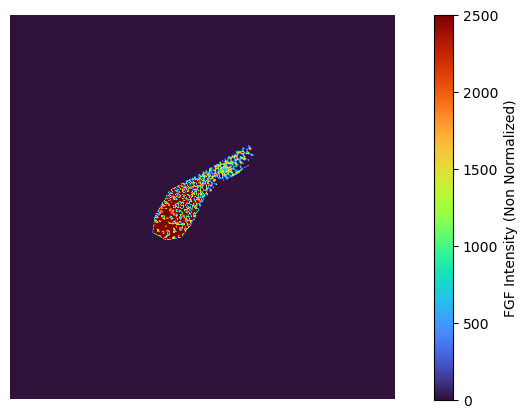

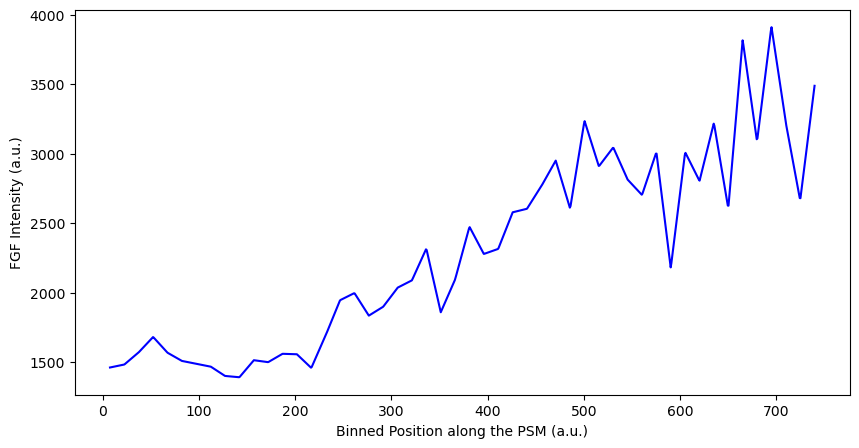

Processing image set 2/5


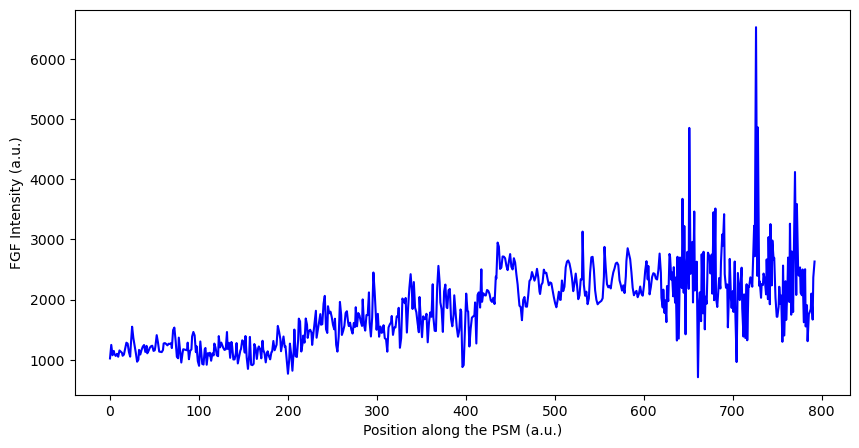

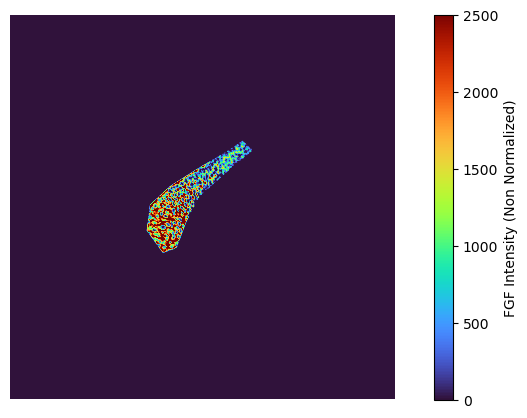

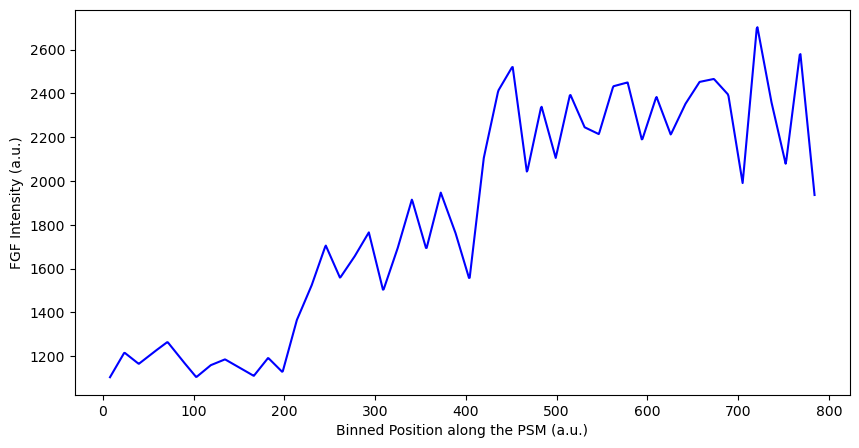

Processing image set 3/5


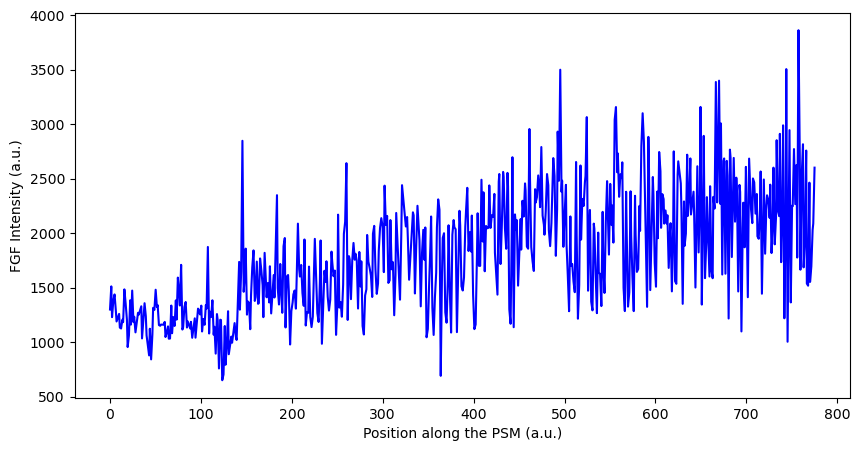

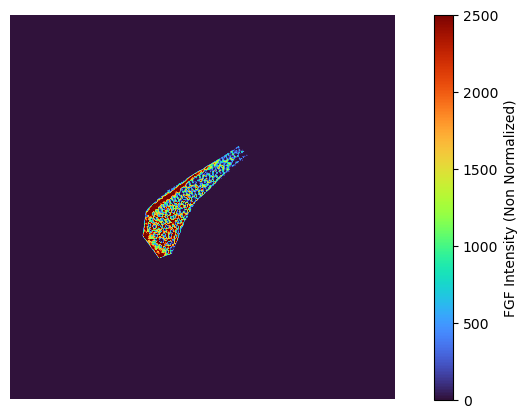

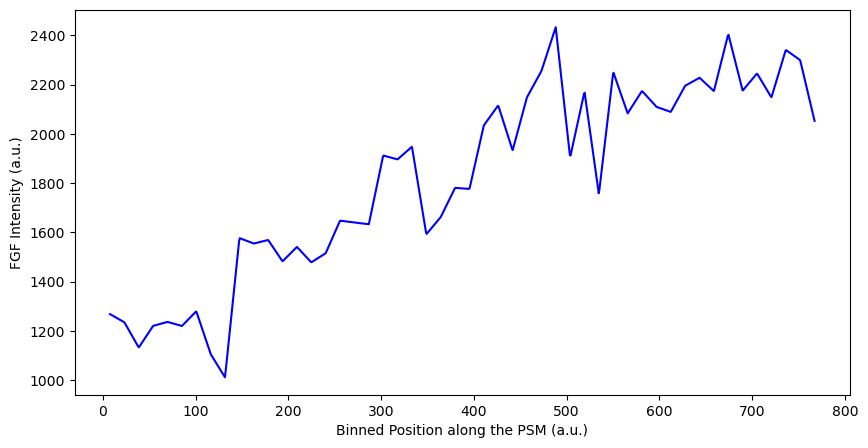

Processing image set 4/5


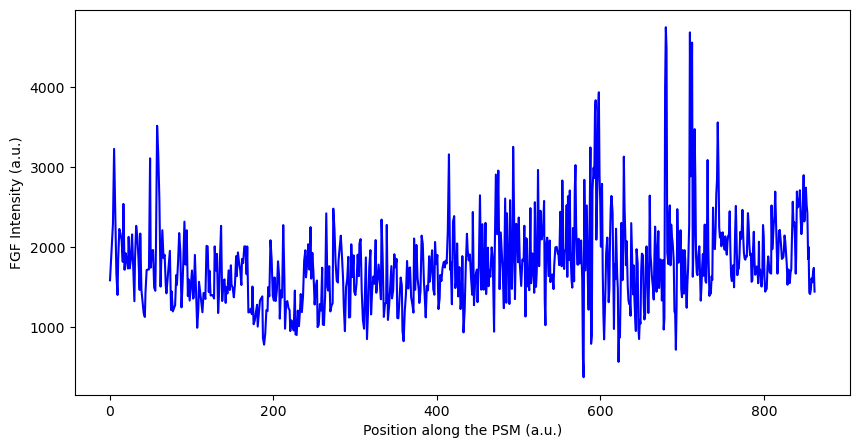

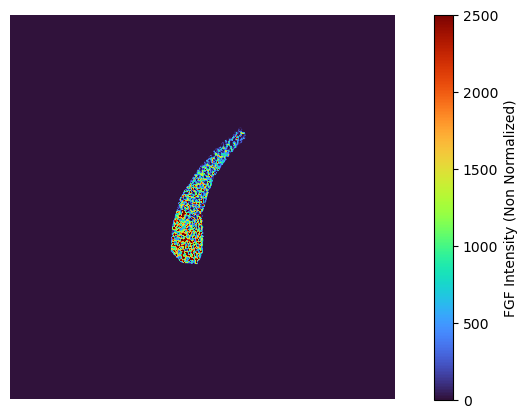

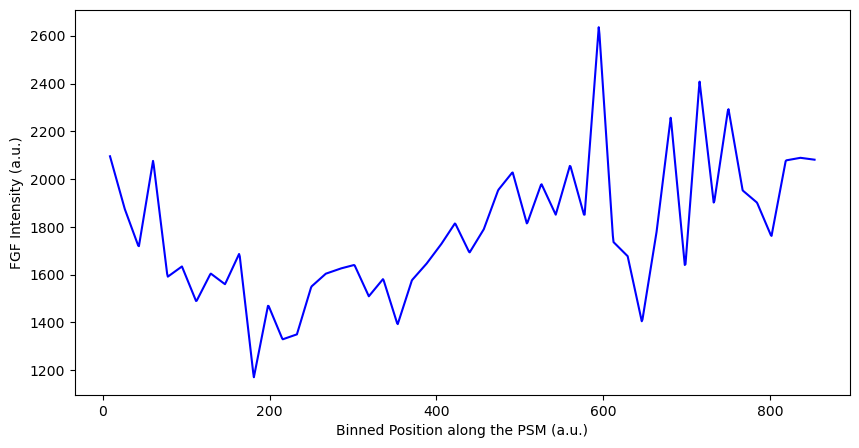

Processing image set 5/5


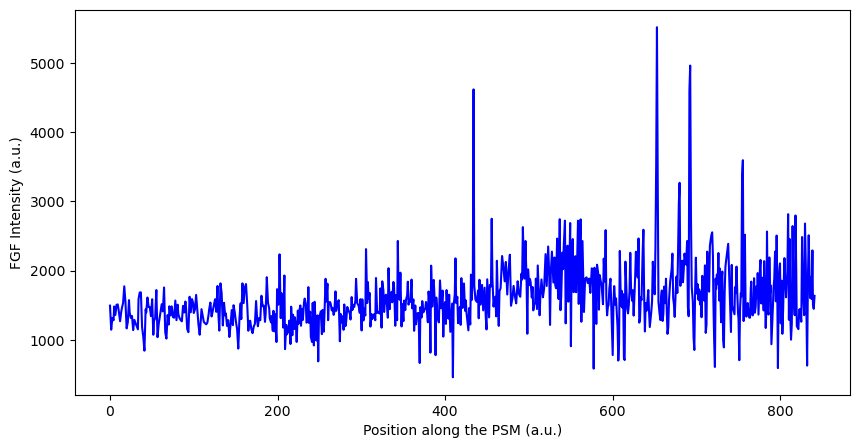

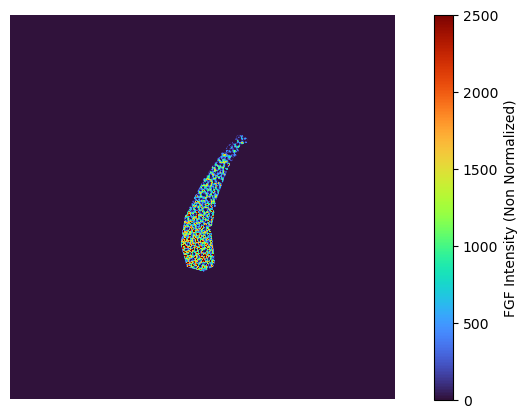

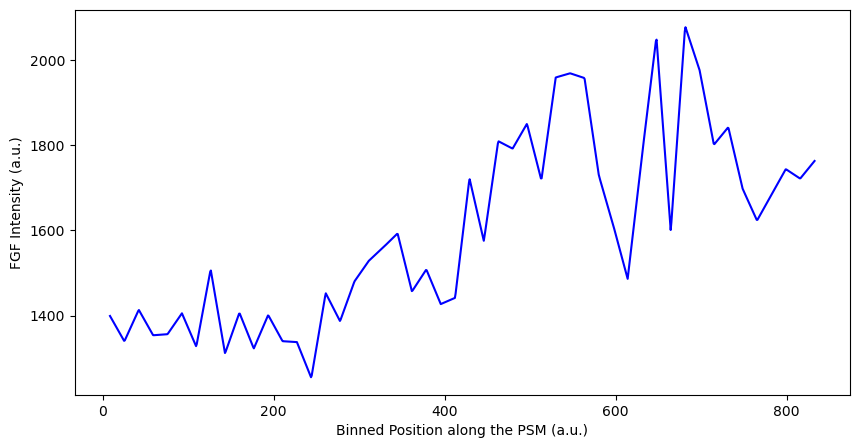

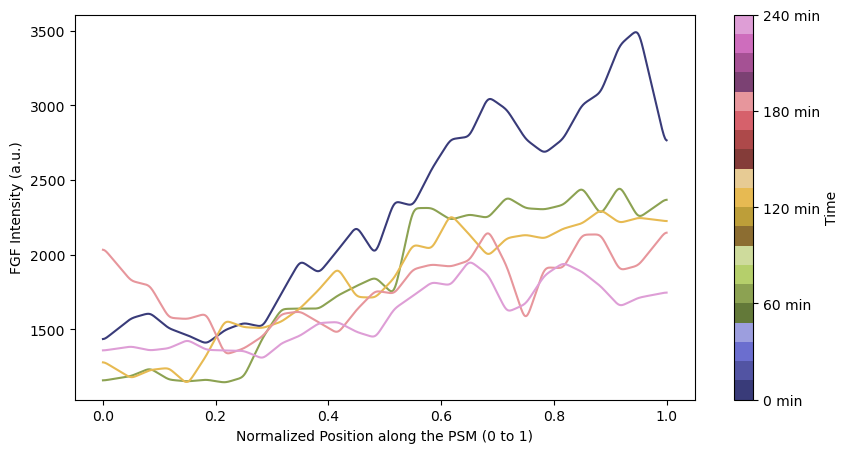

Processing complete. Results saved in E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E4/result


In [21]:
#THE SAME BUT NORMALIZING FOR THE PSM (LOI) LENGHT 
def plot_combined_binned_profiles1(all_interp_positions, all_interp_values, save_path, num_timepoints, loi_lengths):
    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.get_cmap('tab20b')  
    norm = plt.Normalize(vmin=0, vmax=num_timepoints - 1) 

    max_length = max(loi_lengths)
    common_grid = np.linspace(0, 1, 1000)

    for i, (interp_positions, interp_values, loi_length) in enumerate(zip(all_interp_positions, all_interp_values, loi_lengths)):
        #normalized_positions = interp_positions / loi_length 
        normalized_positions = interp_positions / interp_positions[-1]
        interp_func = interp1d(normalized_positions, interp_values, bounds_error=False, fill_value="extrapolate")
        common_values = interp_func(common_grid)
        
        color = cmap(norm(i))  
        #ax.plot(normalized_positions, interp_values, color=color)  
        ax.plot(common_grid, common_values, color=color) 

    ax.set_xlabel('Normalized Position along the PSM (0 to 1)')
    ax.set_ylabel('FGF Intensity (a.u.)')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)  
    cbar.set_label('Time') 
    cbar_ticks = np.linspace(0, num_timepoints - 1, 5).astype(int)  
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{i * 60} min" for i in cbar_ticks])  
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_binned_profiles2(all_interp_positions, all_interp_values, save_path, num_timepoints, loi_lengths):
    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.get_cmap('tab20b')
    norm = plt.Normalize(vmin=0, vmax=num_timepoints - 1)

    common_grid = np.linspace(0, 1, 1000)
    num_bins = 30  # Adjust as needed

    for i, (positions, values, loi_length) in enumerate(zip(all_interp_positions, all_interp_values, loi_lengths)):
        # Normalize positions to [0, 1]
        normalized_positions = positions / positions[-1]

        # Bin the data
        bin_edges = np.linspace(0, 1, num_bins + 1)
        bin_indices = np.digitize(normalized_positions, bin_edges)

        binned_means = np.array([
            values[bin_indices == j].mean() if np.any(bin_indices == j) else np.nan
            for j in range(1, num_bins + 1)
        ])

        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Interpolate and smooth
        valid_mask = ~np.isnan(binned_means)
        interp_func = interp1d(bin_centers[valid_mask], binned_means[valid_mask], kind='linear', fill_value="extrapolate")
        interpolated_values = interp_func(common_grid)

        smoothed_values = gaussian_filter1d(interpolated_values, sigma=5)

        color = cmap(norm(i))
        ax.plot(common_grid, smoothed_values, color=color)

    ax.set_xlabel('Normalized Position along the PSM (0 to 1)')
    ax.set_ylabel('FGF Intensity (a.u.)')

    # Colorbar setup
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Time')
    cbar_ticks = np.linspace(0, num_timepoints - 1, 5).astype(int)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{i * 60} min" for i in cbar_ticks])

    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def calculate_loi_length(loi_coords):
    distances = np.sqrt(np.sum(np.diff(loi_coords, axis=0)**2, axis=1))
    return np.sum(distances)

def fgf_quantification_pipeline_multiple1(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir):
    fgf_images, fgf_masks, psm_masks, lois, dextran_images = load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir)
    
    all_interp_positions = []
    all_interp_values = []
    loi_lengths = []

    for i, (fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path) in enumerate(zip(fgf_images, fgf_masks, psm_masks, lois, dextran_images)):
        print(f"Processing image set {i + 1}/{len(fgf_images)}")
        
        image_results_dir = os.path.join(results_dir, f"image_set_{i + 1}")
        os.makedirs(image_results_dir, exist_ok=True)

        interp_positions, interp_values, loi_length = fgf_quantification_pipeline_with_euclidean_no_normalization1(
            fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, image_results_dir
        )

        all_interp_positions.append(interp_positions)
        all_interp_values.append(interp_values)
        loi_lengths.append(loi_length)

    combined_plot_path = os.path.join(results_dir, 'combined_binned_profiles.svg')
    plot_combined_binned_profiles2(all_interp_positions, all_interp_values, combined_plot_path, num_timepoints=len(fgf_images), loi_lengths=loi_lengths)
    
    print(f"Processing complete. Results saved in {results_dir}")

def fgf_quantification_pipeline_with_euclidean_no_normalization1(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, results_dir):
    fgf, fgf_mask, psm_mask, loi, _ = load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path)
    fgf_psm_mask = create_combined_mask(fgf_mask, psm_mask)
    positive_pixels, fgf_intensities = find_positive_pixels(fgf_psm_mask, fgf)

    normalized_intensities = fgf_intensities.astype(np.float64)  # Nessuna normalizzazione

    loi_coords = np.column_stack(np.where(loi))
    loi_length = calculate_loi_length(loi_coords)  # Calcola la lunghezza della LOI

    nearest_loi_points = calculate_nearest_loi_points(positive_pixels, loi_coords)
    intensity_profile = calculate_intensity_profile(nearest_loi_points, normalized_intensities, loi_coords)

    rightmost_loi_point = loi_coords[np.argmax(loi_coords[:, 1])]
    distances_from_rightmost = distance.cdist([rightmost_loi_point], loi_coords, metric='euclidean').flatten()

    sorted_indices = np.argsort(distances_from_rightmost)
    sorted_distances = distances_from_rightmost[sorted_indices]
    sorted_intensity_profile = intensity_profile[sorted_indices]

    non_zero_mask = sorted_intensity_profile > 0
    interp_func = interp1d(sorted_distances[non_zero_mask], sorted_intensity_profile[non_zero_mask], bounds_error=False, fill_value="extrapolate")
    interpolated_intensities = interp_func(sorted_distances)

    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances, interpolated_intensities, c='b')
    plt.xlabel('Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    plot_path = os.path.join(results_dir, 'intensity_profile_no_normalization.svg')
    plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    filtered_fgf_image_path = os.path.join(results_dir, 'filtered_fgf_image_non_normalized.svg')
    fgf_psm_binary = fgf_psm_mask > 0
    visualize_filtered_fgf(fgf, fgf_psm_binary, filtered_fgf_image_path)

    num_bins = 50
    bin_edges = np.linspace(0, sorted_distances[-1], num_bins + 1)
    bin_indices = np.digitize(sorted_distances, bin_edges)

    binned_intensities = np.array([interpolated_intensities[bin_indices == i].mean() for i in range(1, num_bins + 1)])
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

    interp_bin_func = interp1d(bin_centers, binned_intensities, kind='linear', fill_value="extrapolate")
    interp_positions = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    interp_values = interp_bin_func(interp_positions)

    plt.figure(figsize=(10, 5))
    plt.plot(interp_positions, interp_values, c='b')
    plt.xlabel('Binned Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    binned_plot_path = os.path.join(results_dir, 'binned_plot_no_normalization.svg')
    plt.savefig(binned_plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return interp_positions, interp_values, loi_length

image_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E4/fgf'
mask_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E4/fgf_mask/'
psm_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E4/tissue/'
loi_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E4/loi/'
dextran_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E4/fgf/'
results_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E4/result'


fgf_quantification_pipeline_multiple1(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir)

Processing image set 1/3
Processing image set 2/3
Processing image set 3/3


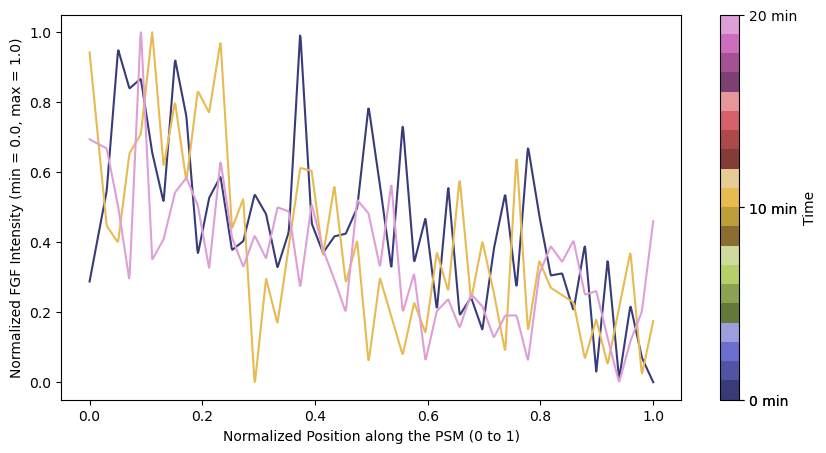

Processing complete. Results saved in E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/result


In [12]:
def plot_combined_binned_profiles5(all_interp_positions, all_interp_values, save_path, num_timepoints, loi_lengths):
    """
    Plots combined normalized FGF intensity profiles across multiple timepoints, ensuring all profiles
    have a minimum value of 0.0 and maximum value of 1.0 in the plot.
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.get_cmap('tab20b')  
    norm = plt.Normalize(vmin=0, vmax=num_timepoints - 1) 

    max_length = max(loi_lengths)
    common_grid = np.linspace(0, 1, 1000)

    for i, (interp_positions, interp_values, loi_length) in enumerate(zip(all_interp_positions, all_interp_values, loi_lengths)):
        normalized_positions = interp_positions / interp_positions[-1]  # Normalize x by the max position
        
        # Normalize y so that the minimum is 0.0 and maximum is 1.0
        min_value = min(interp_values)
        max_value = max(interp_values)
        normalized_values = (interp_values - min_value) / (max_value - min_value)

        # Interpolate on a common grid
        interp_func = interp1d(normalized_positions, normalized_values, bounds_error=False, fill_value="extrapolate")
        common_values = interp_func(common_grid)
        
        color = cmap(norm(i))  
        ax.plot(common_grid, common_values, color=color) 

    ax.set_xlabel('Normalized Position along the PSM (0 to 1)')
    ax.set_ylabel('Normalized FGF Intensity (min = 0.0, max = 1.0)')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)  
    cbar.set_label('Time') 
    cbar_ticks = np.linspace(0, num_timepoints - 1, 5).astype(int)  
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{i * 10} min" for i in cbar_ticks])  
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def fgf_quantification_pipeline_multiple5(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir):
    fgf_images, fgf_masks, psm_masks, lois, dextran_images = load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir)
    
    all_interp_positions = []
    all_interp_values = []
    loi_lengths = []

    for i, (fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path) in enumerate(zip(fgf_images, fgf_masks, psm_masks, lois, dextran_images)):
        print(f"Processing image set {i + 1}/{len(fgf_images)}")
        
        image_results_dir = os.path.join(results_dir, f"image_set_{i + 1}")
        os.makedirs(image_results_dir, exist_ok=True)

        interp_positions, interp_values, loi_length = fgf_quantification_pipeline_with_euclidean_no_normalization5(
            fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, image_results_dir
        )

        all_interp_positions.append(interp_positions)
        all_interp_values.append(interp_values)
        loi_lengths.append(loi_length)

    combined_plot_path = os.path.join(results_dir, 'combined_binned_profiles_norm1.svg')
    plot_combined_binned_profiles5(all_interp_positions, all_interp_values, combined_plot_path, num_timepoints=len(fgf_images), loi_lengths=loi_lengths)
    
    print(f"Processing complete. Results saved in {results_dir}")

def calculate_loi_length(loi_coords):
    distances = np.sqrt(np.sum(np.diff(loi_coords, axis=0)**2, axis=1))
    return np.sum(distances)

def fgf_quantification_pipeline_with_euclidean_no_normalization5(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, results_dir):
    fgf, fgf_mask, psm_mask, loi, _ = load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path)
    fgf_psm_mask = create_combined_mask(fgf_mask, psm_mask)
    positive_pixels, fgf_intensities = find_positive_pixels(fgf_psm_mask, fgf)

    normalized_intensities = fgf_intensities.astype(np.float64)

    loi_coords = np.column_stack(np.where(loi))
    loi_length = calculate_loi_length(loi_coords)

    nearest_loi_points = calculate_nearest_loi_points(positive_pixels, loi_coords)
    intensity_profile = calculate_intensity_profile(nearest_loi_points, normalized_intensities, loi_coords)

    rightmost_loi_point = loi_coords[np.argmax(loi_coords[:, 1])]
    distances_from_rightmost = distance.cdist([rightmost_loi_point], loi_coords, metric='euclidean').flatten()

    sorted_indices = np.argsort(distances_from_rightmost)
    sorted_distances = distances_from_rightmost[sorted_indices]
    sorted_intensity_profile = intensity_profile[sorted_indices]

    non_zero_mask = sorted_intensity_profile > 0
    interp_func = interp1d(sorted_distances[non_zero_mask], sorted_intensity_profile[non_zero_mask], bounds_error=False, fill_value="extrapolate")
    interpolated_intensities = interp_func(sorted_distances)

    num_bins = 50
    bin_edges = np.linspace(0, sorted_distances[-1], num_bins + 1)
    bin_indices = np.digitize(sorted_distances, bin_edges)

    binned_intensities = np.array([interpolated_intensities[bin_indices == i].mean() for i in range(1, num_bins + 1)])
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

    interp_bin_func = interp1d(bin_centers, binned_intensities, kind='linear', fill_value="extrapolate")
    interp_positions = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    interp_values = interp_bin_func(interp_positions)

    return interp_positions, interp_values, loi_length

image_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/fgf'
mask_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/fgf_mask/'
psm_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/tissue/'
loi_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/loi/'
dextran_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/fgf/'
results_dir = 'E:/Agnese/20250326-lsm980-fgf/2025-03-26/14ss_every_h/E1/result'

fgf_quantification_pipeline_multiple5(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir)

Processing image set 1/30


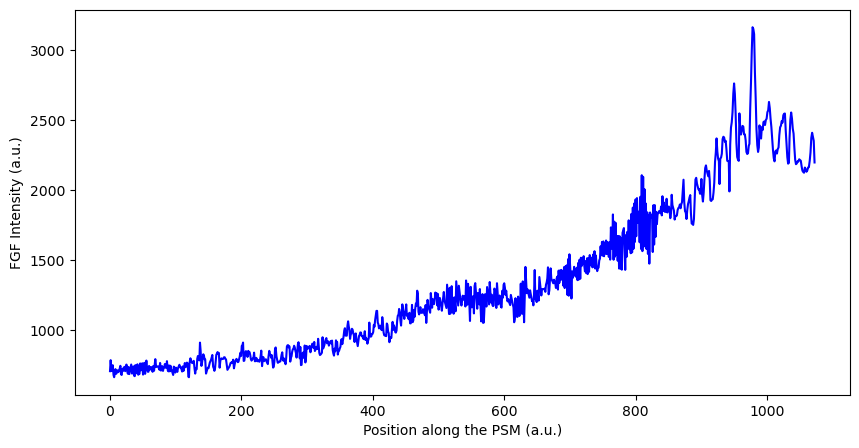

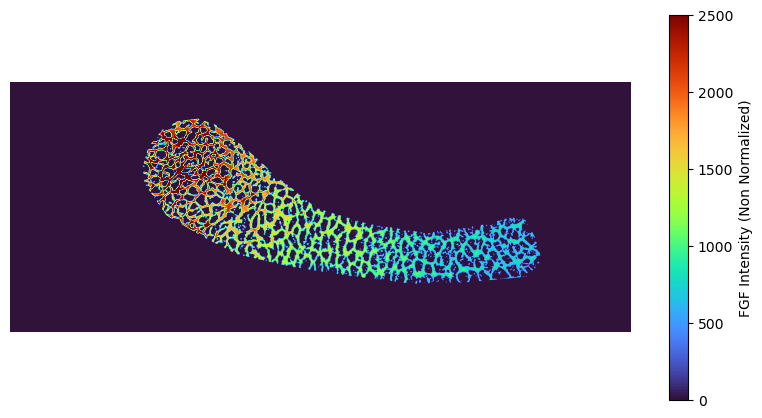

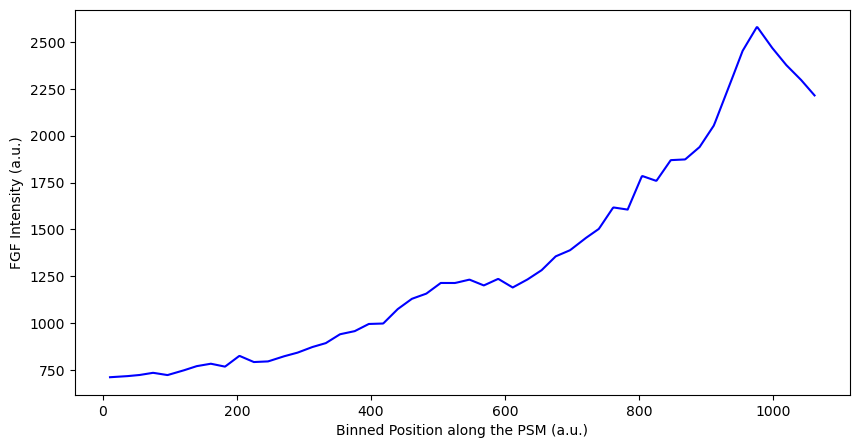

Processing image set 2/30


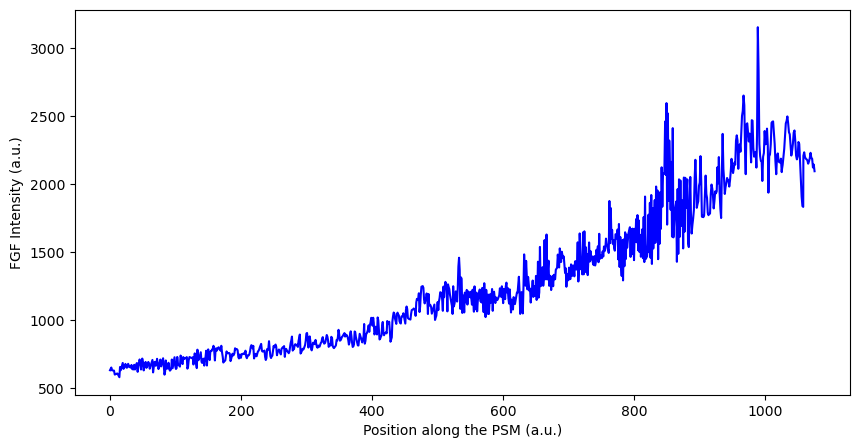

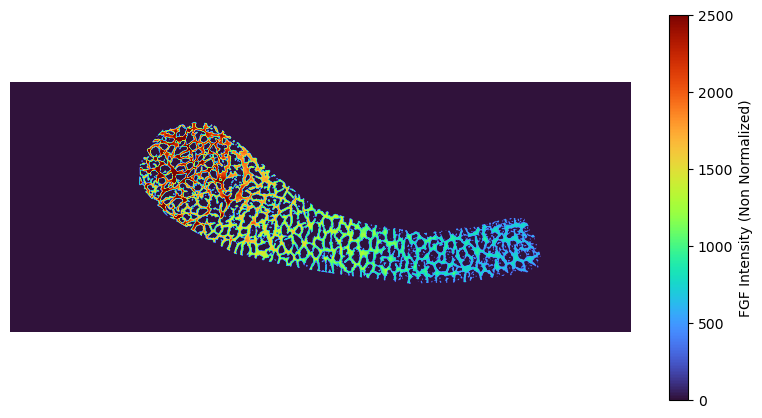

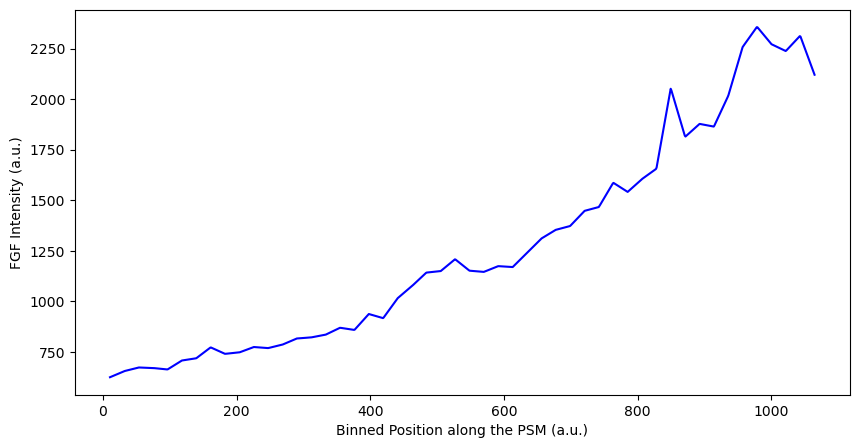

Processing image set 3/30


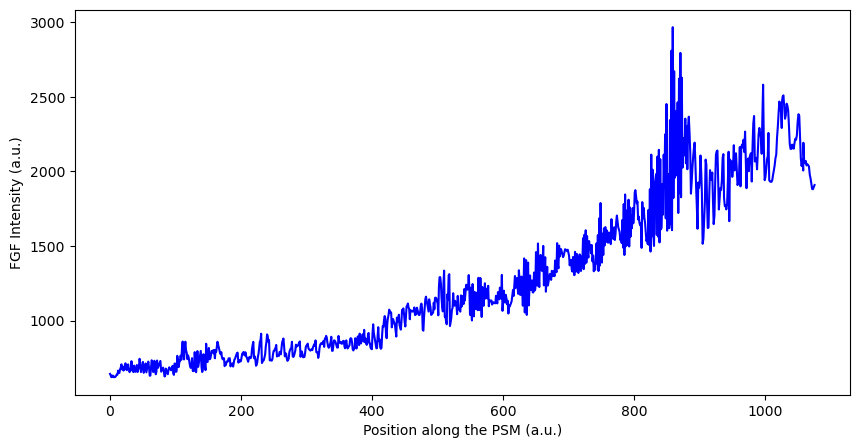

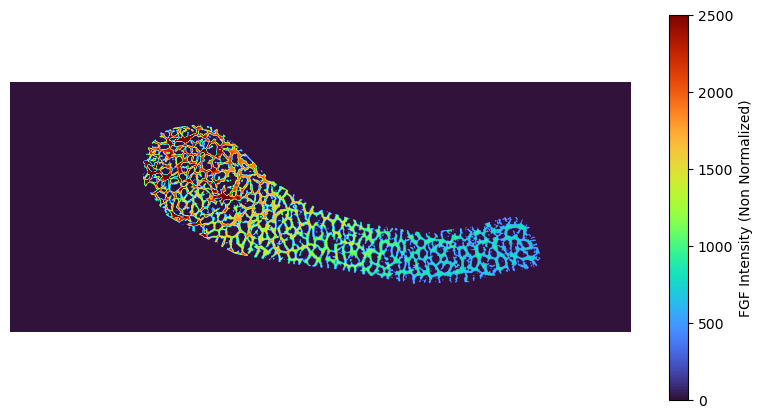

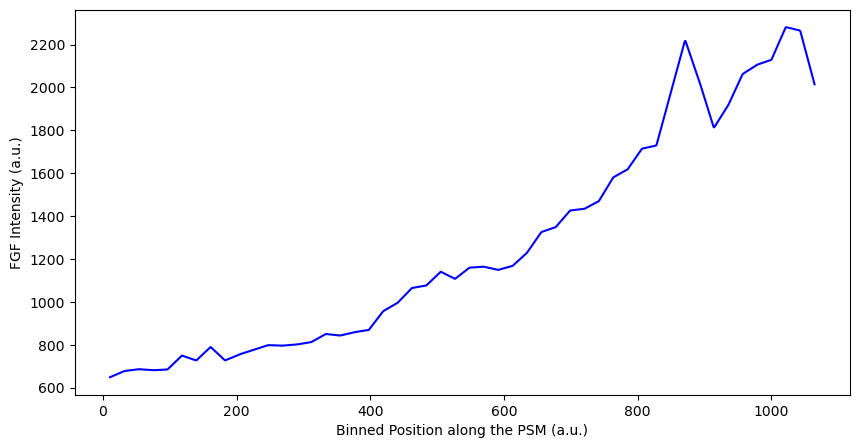

Processing image set 4/30


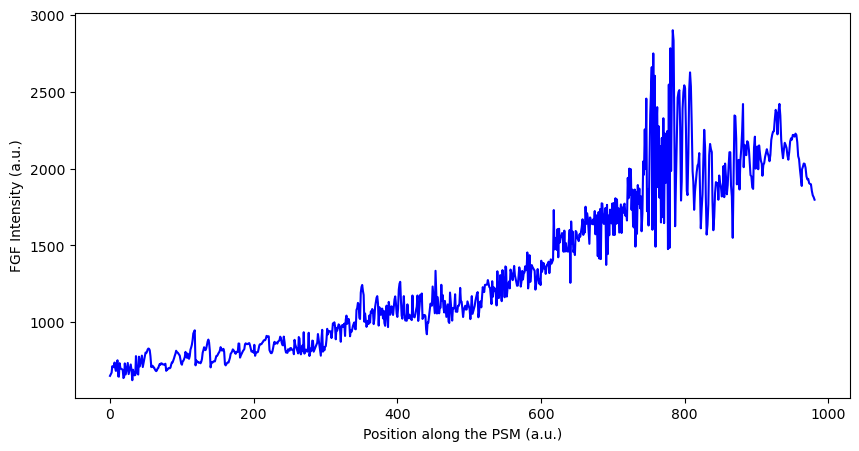

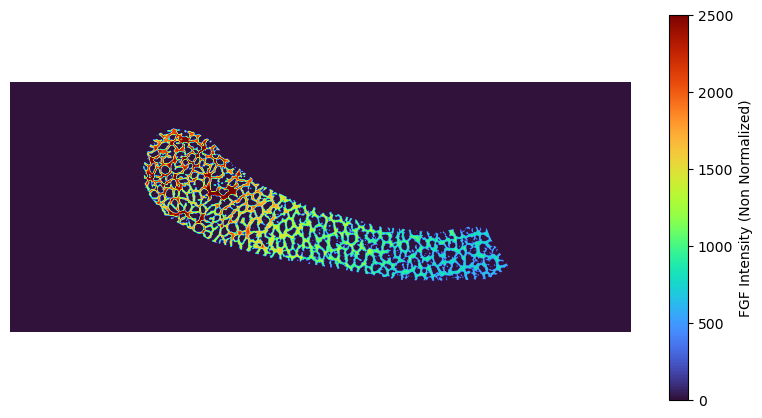

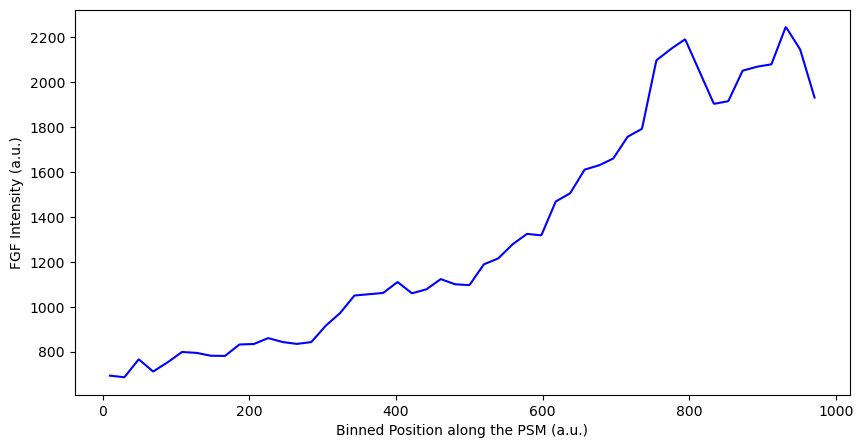

Processing image set 5/30


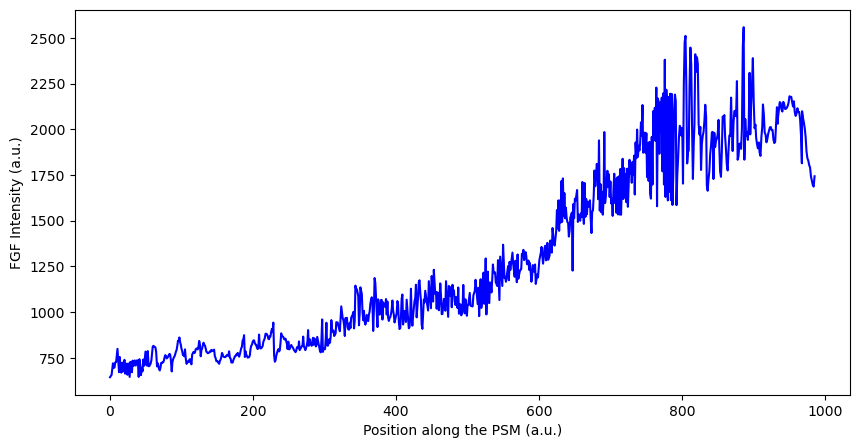

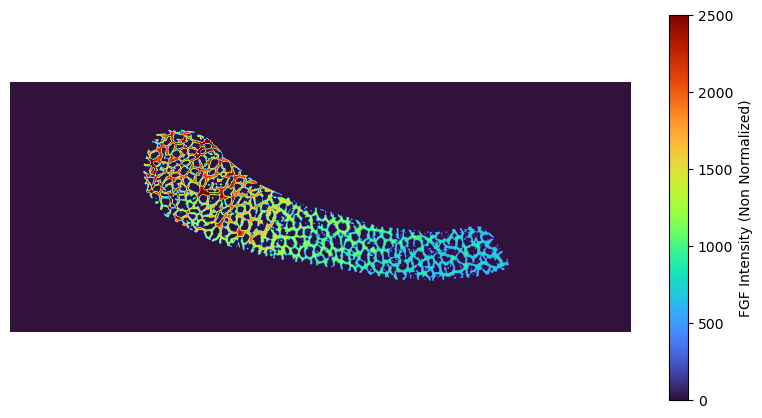

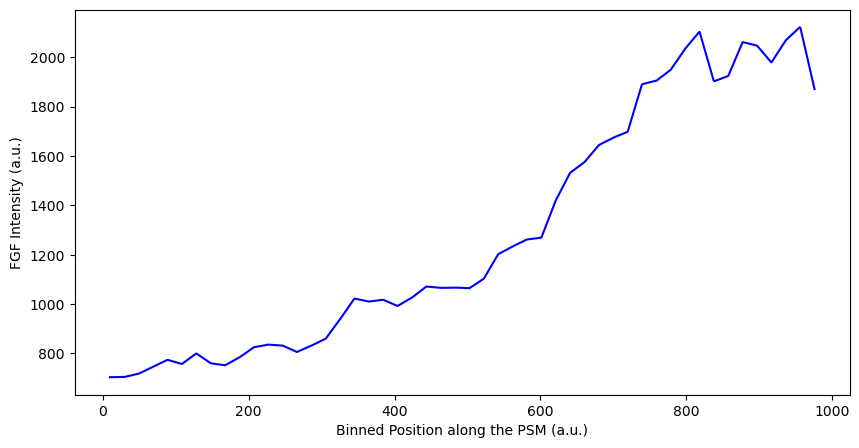

Processing image set 6/30


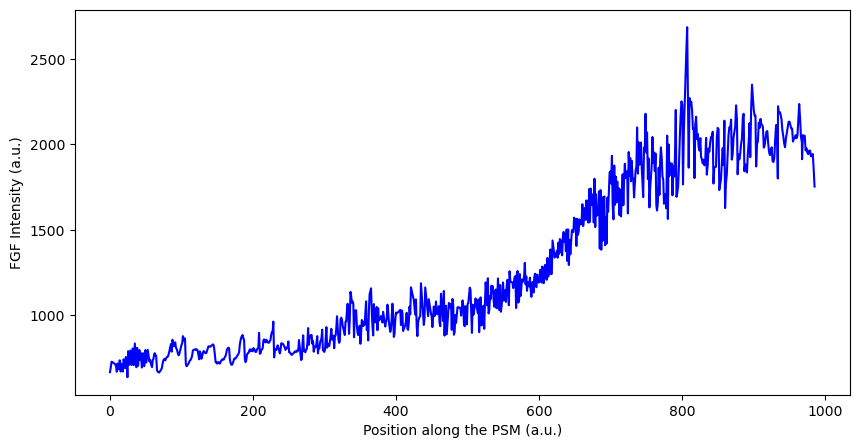

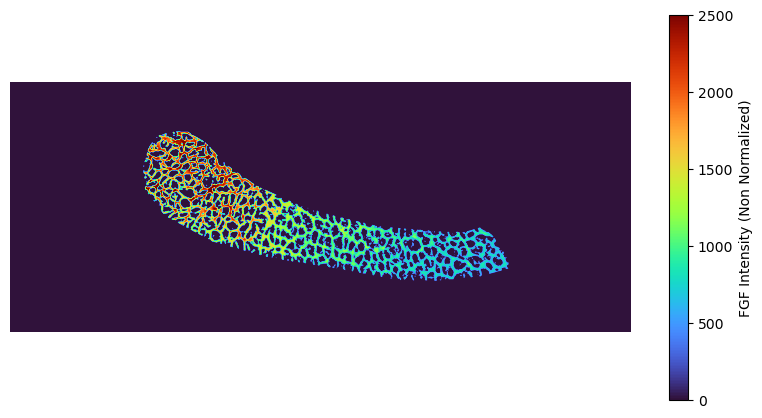

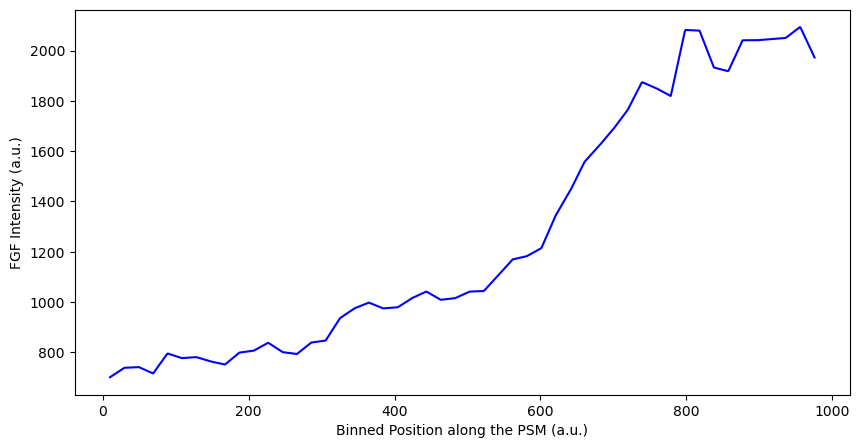

Processing image set 7/30


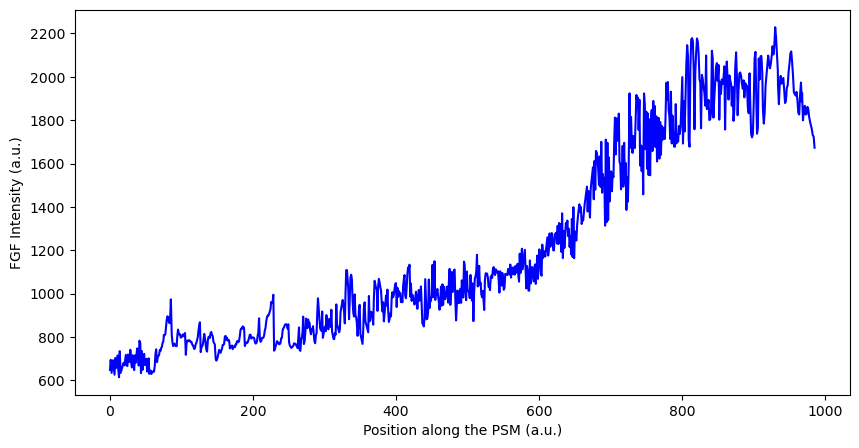

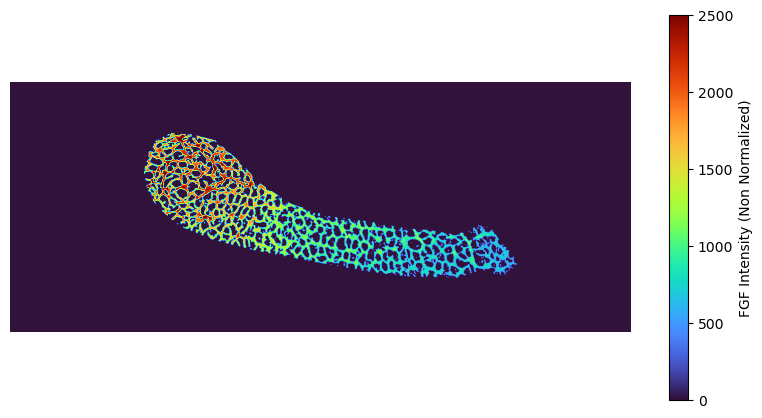

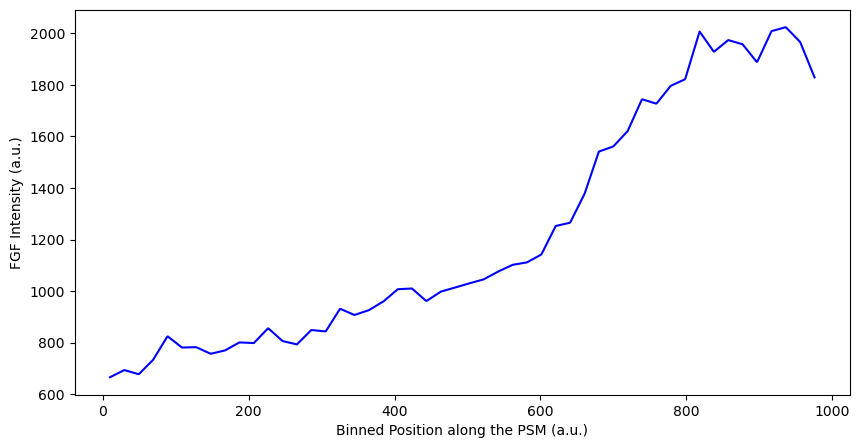

Processing image set 8/30


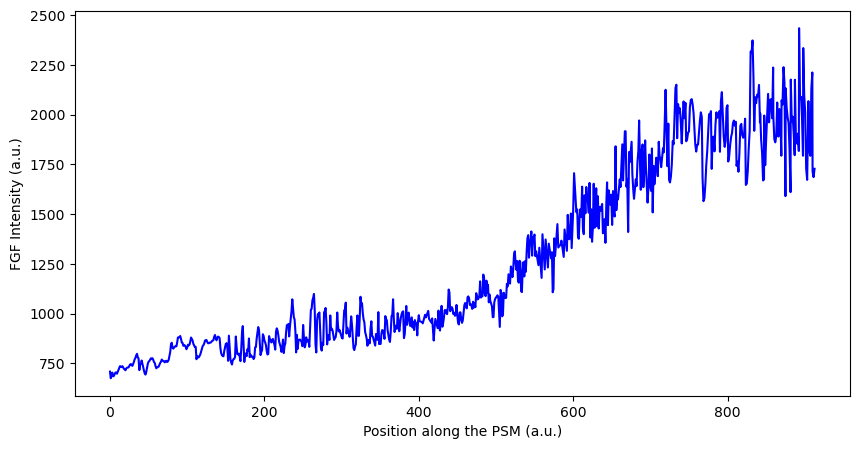

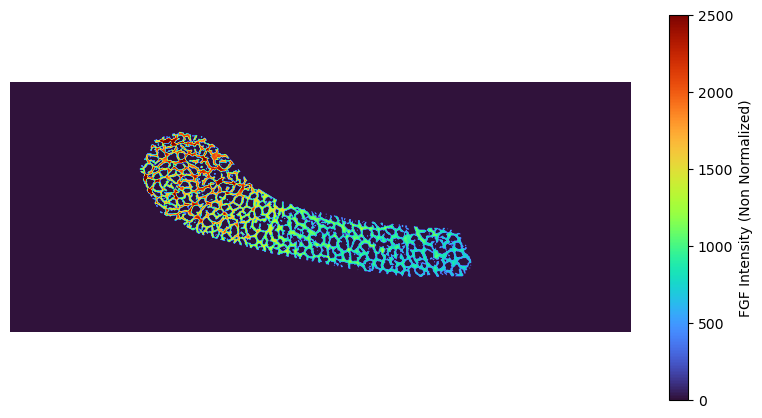

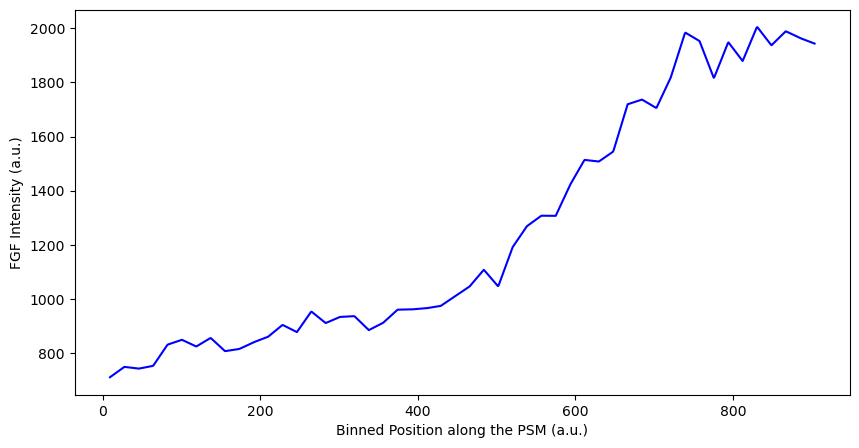

Processing image set 9/30


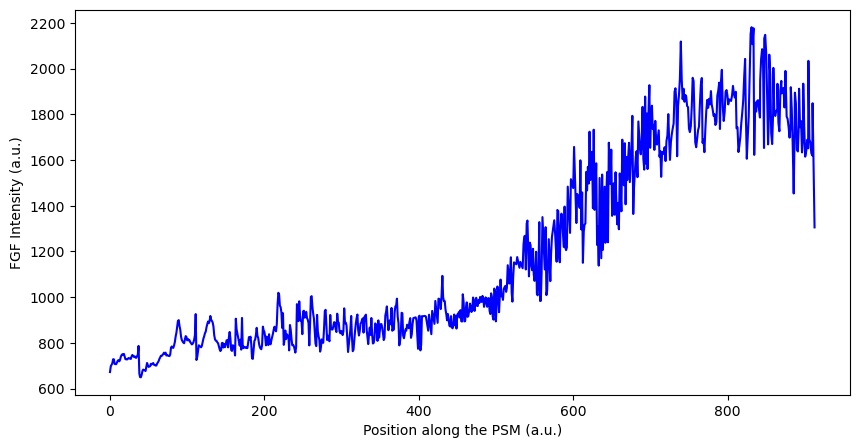

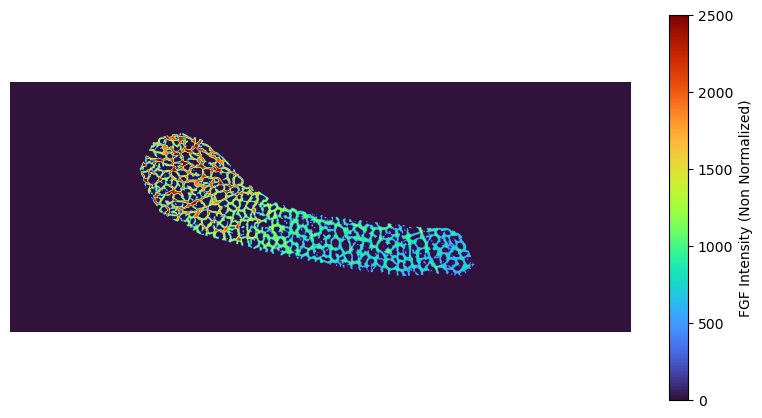

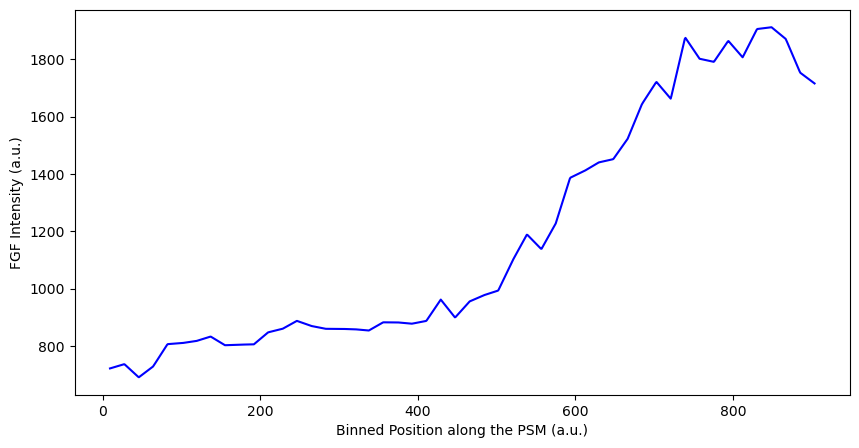

Processing image set 10/30


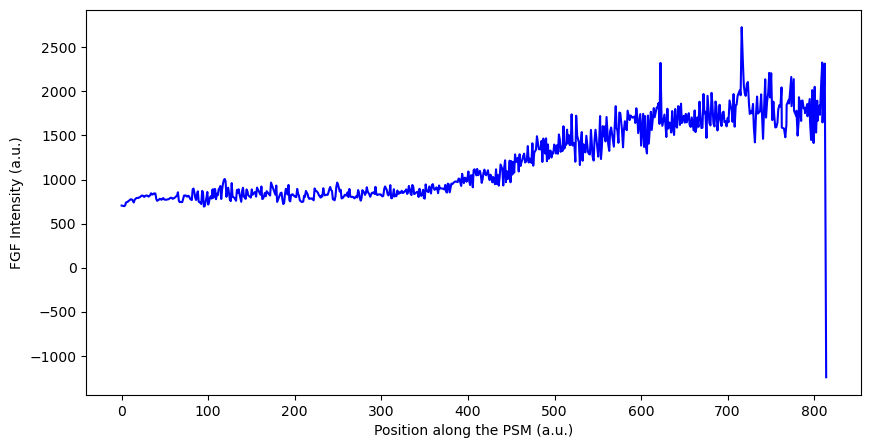

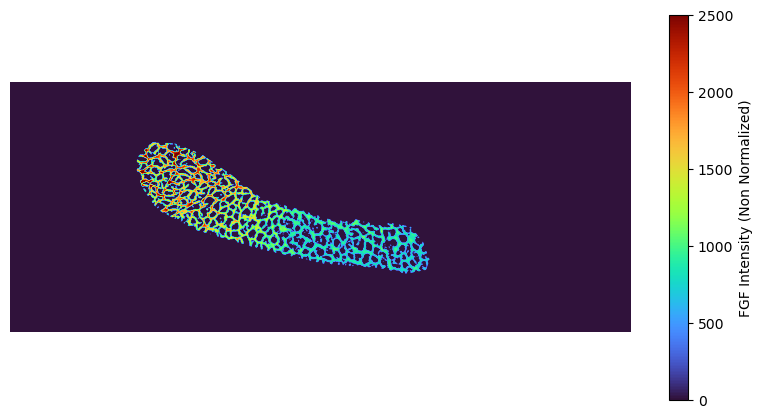

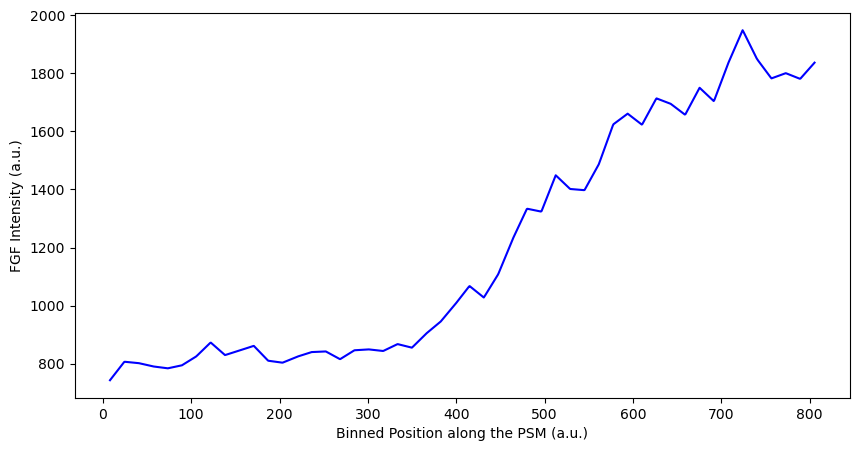

Processing image set 11/30


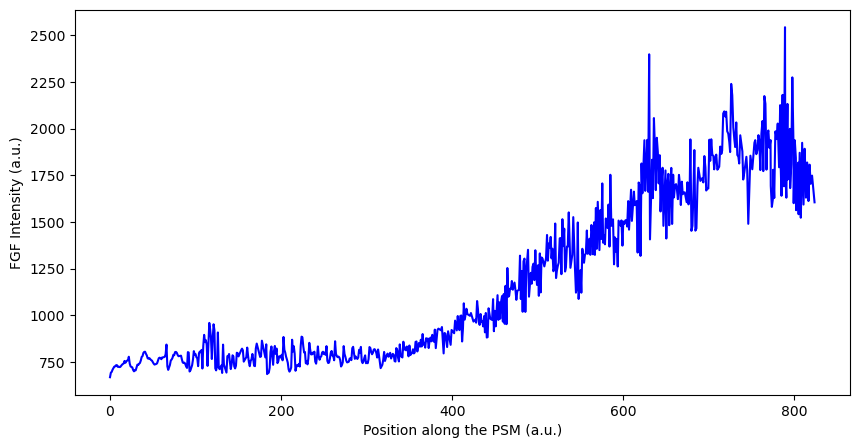

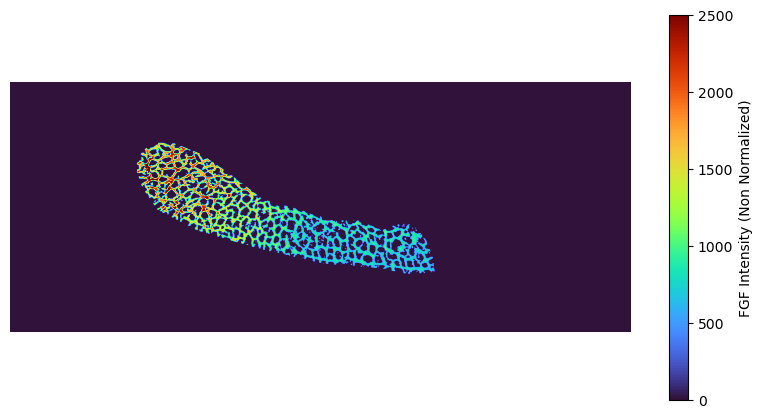

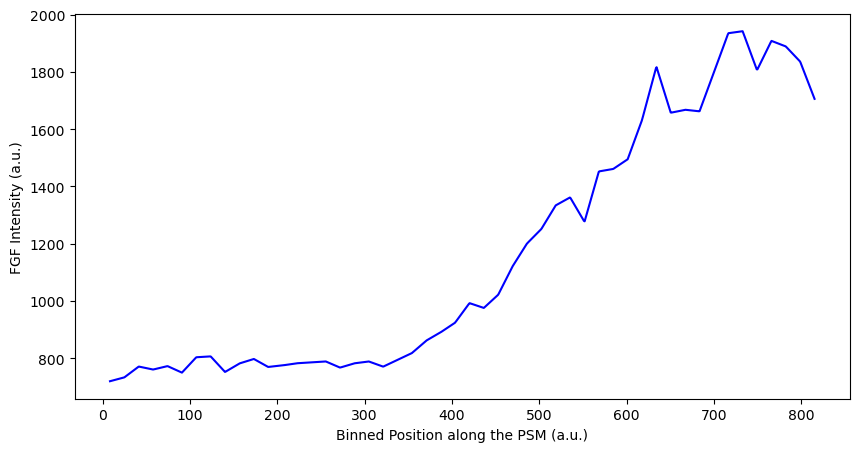

Processing image set 12/30


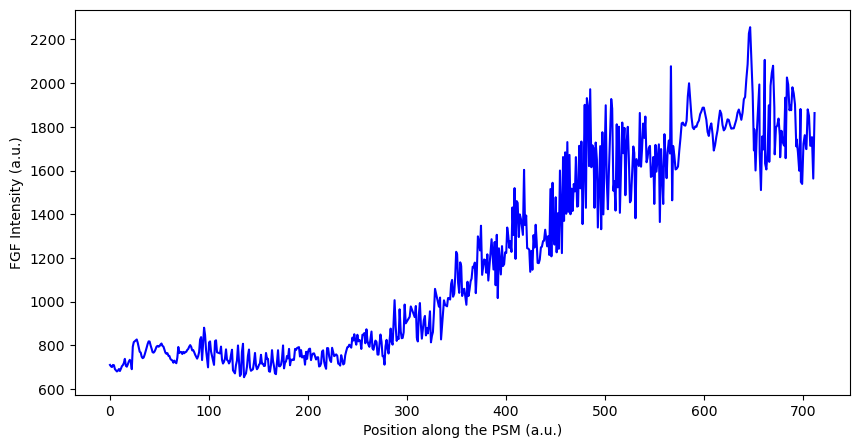

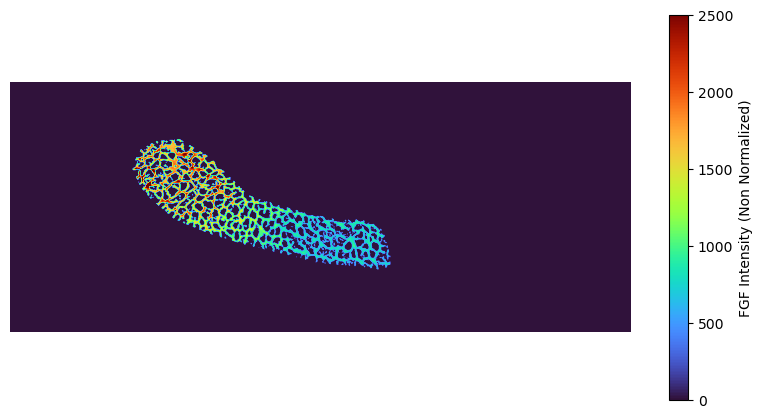

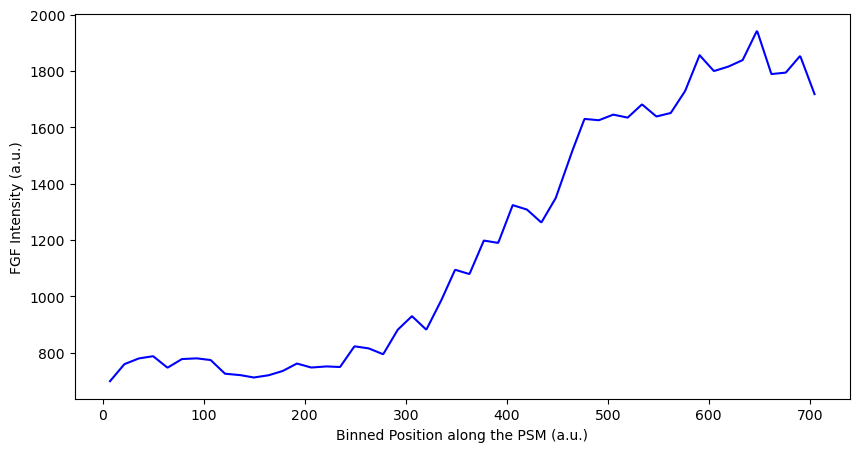

Processing image set 13/30


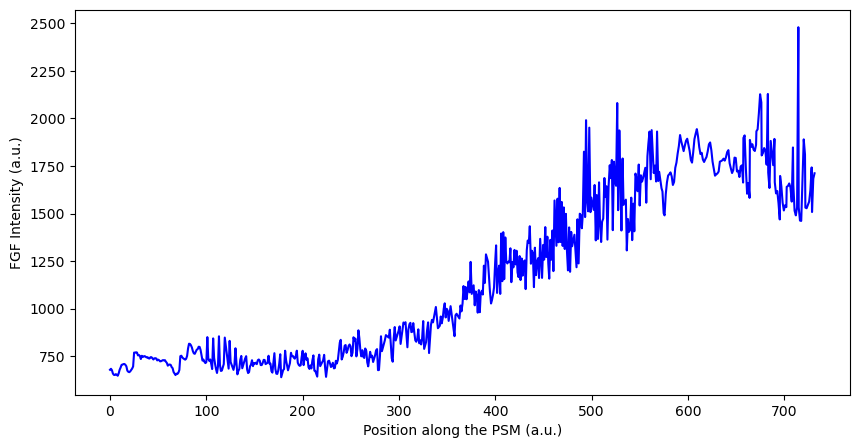

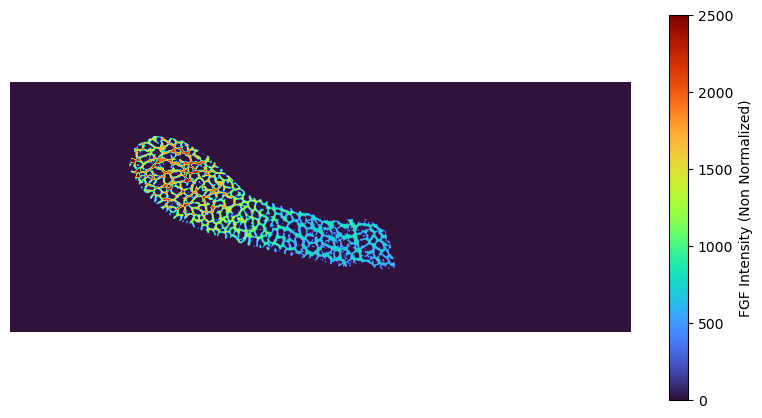

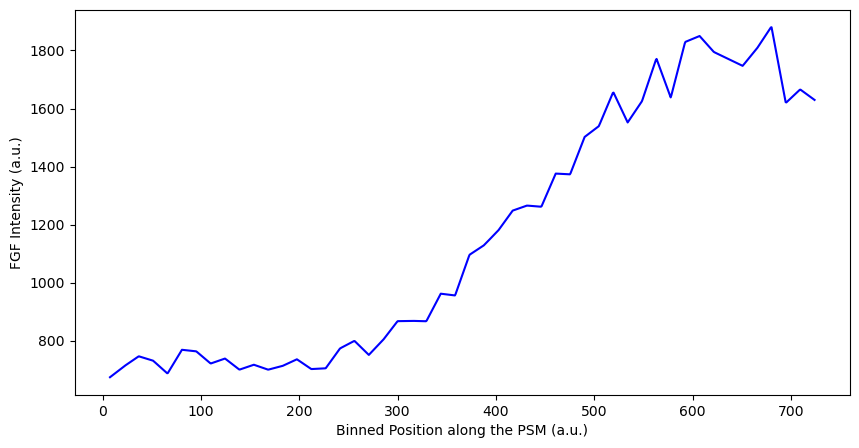

Processing image set 14/30


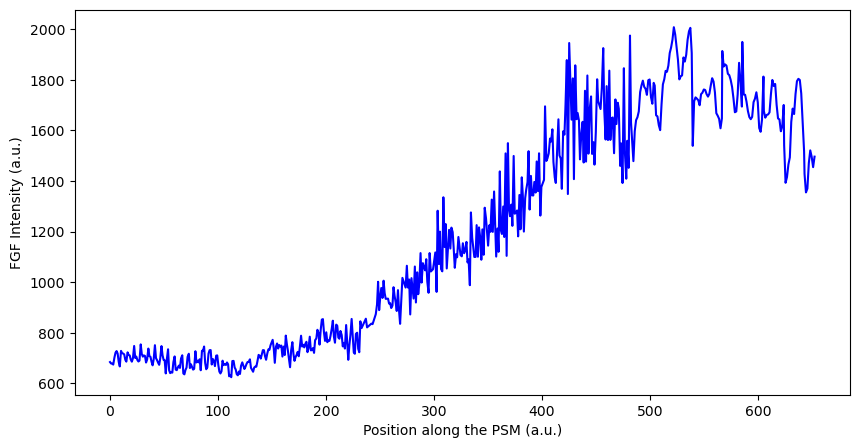

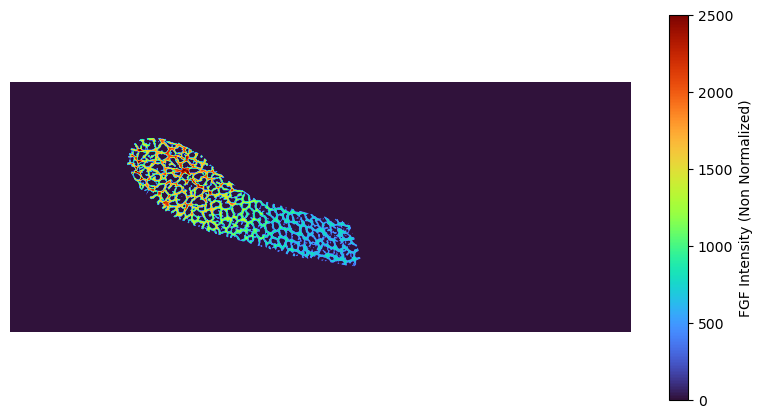

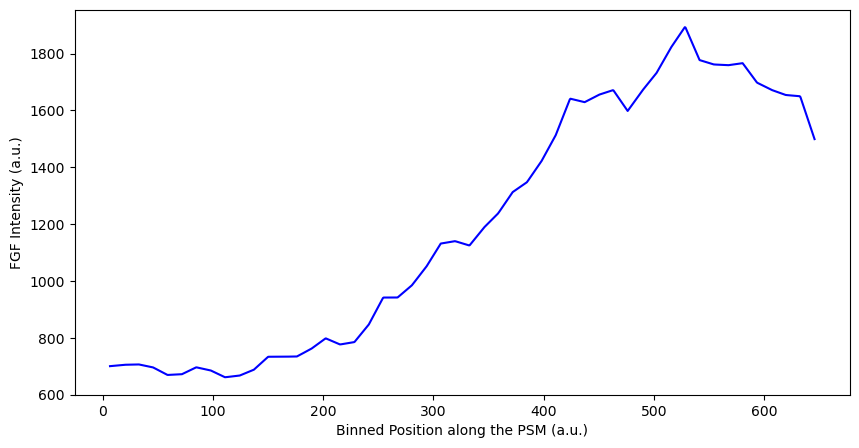

Processing image set 15/30


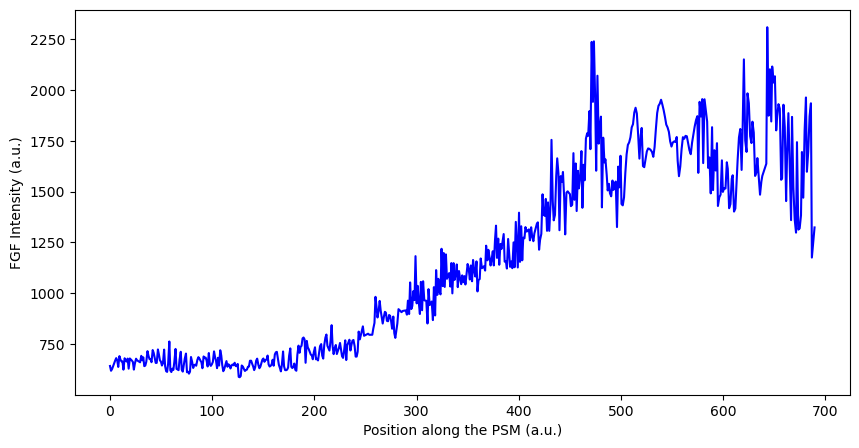

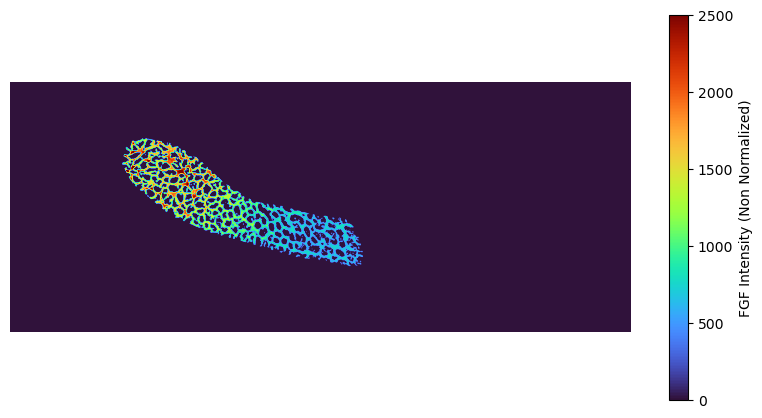

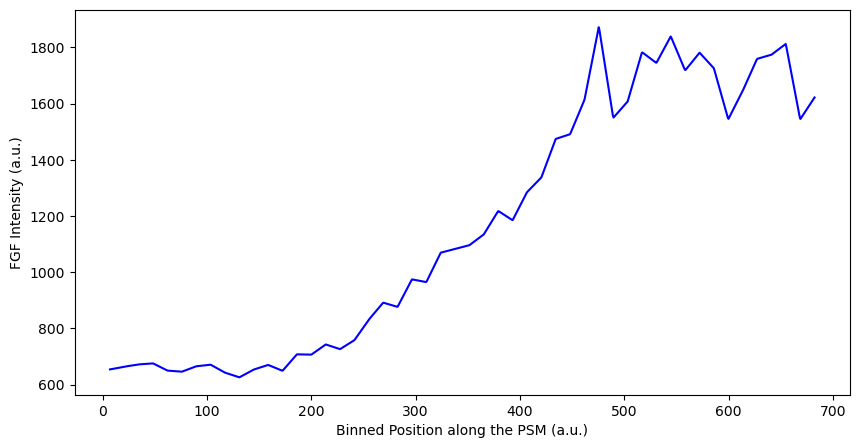

Processing image set 16/30


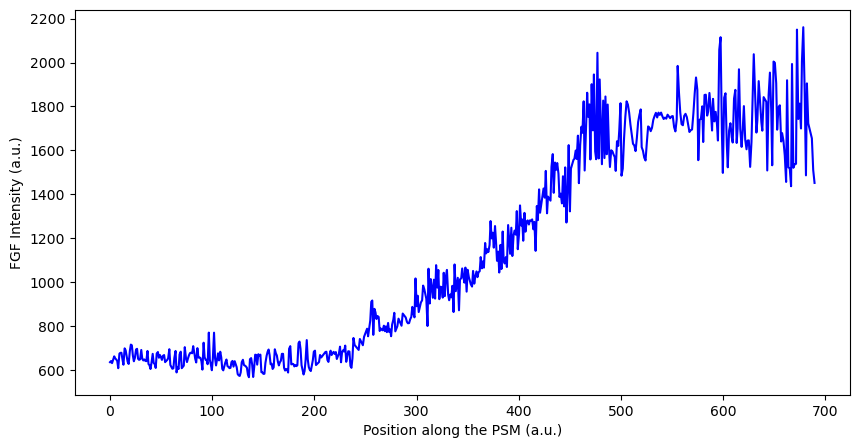

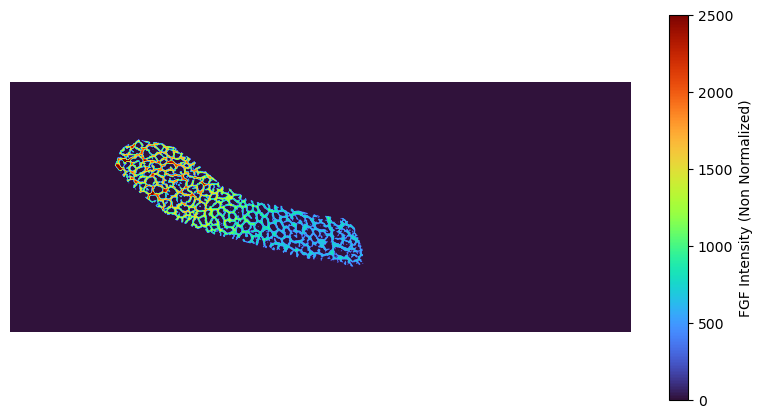

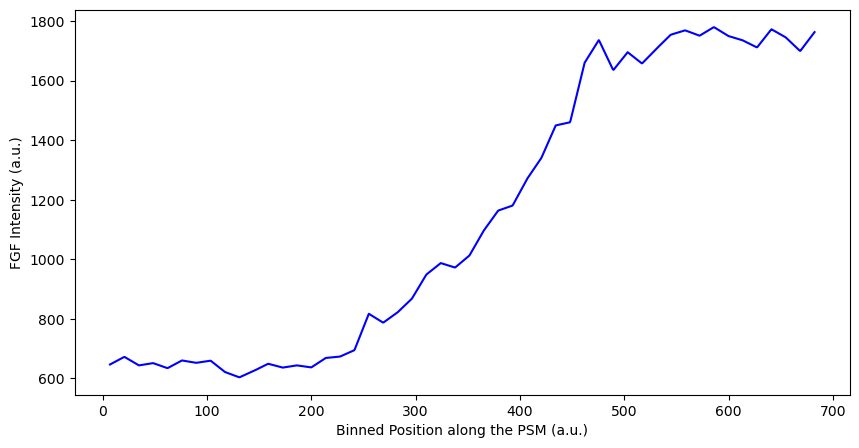

Processing image set 17/30


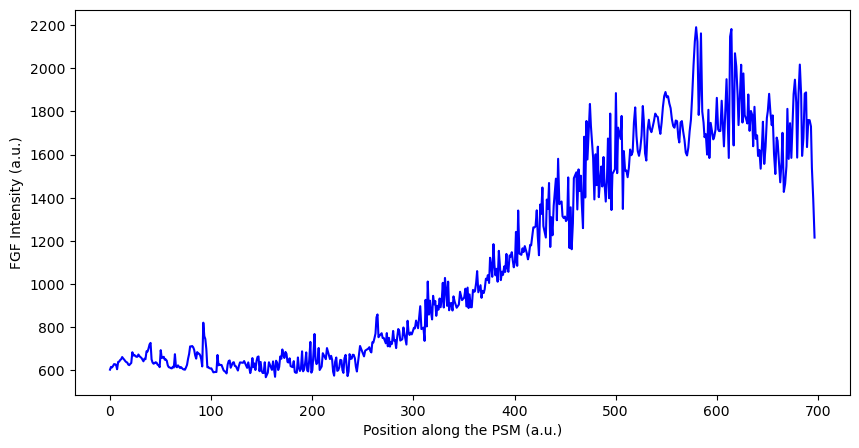

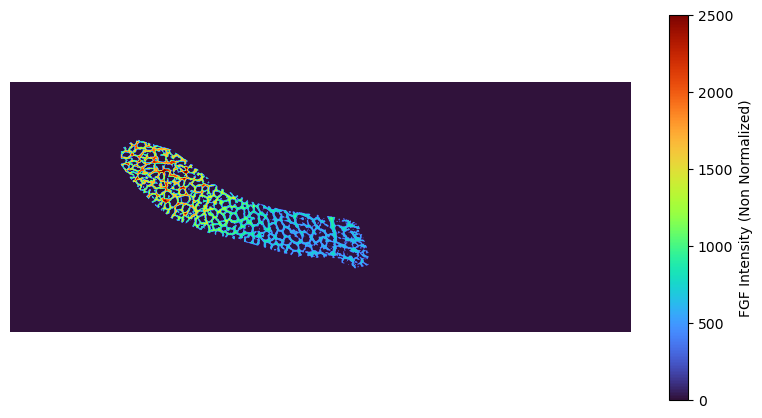

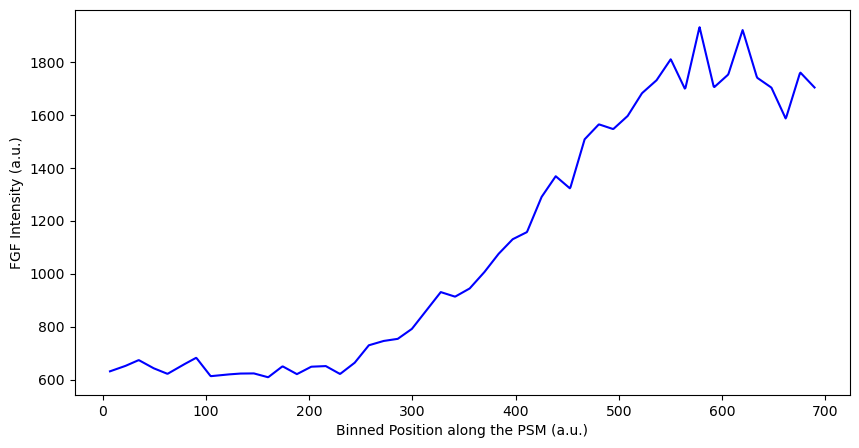

Processing image set 18/30


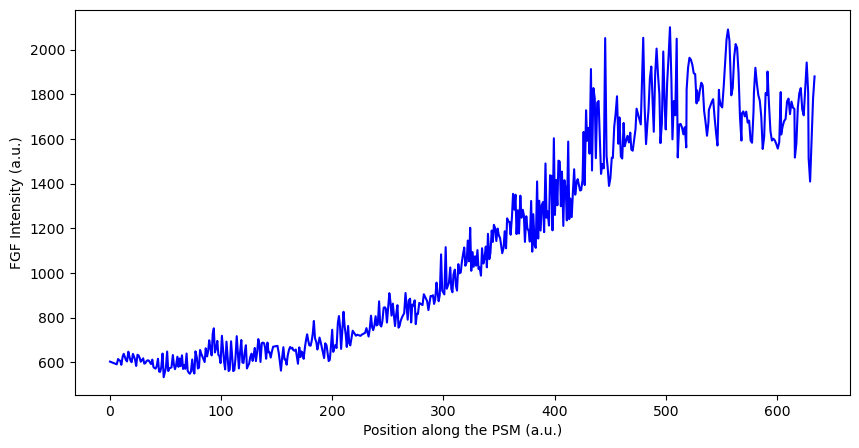

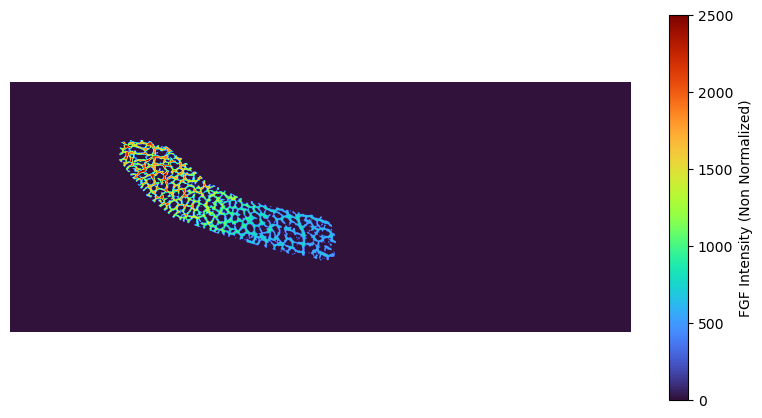

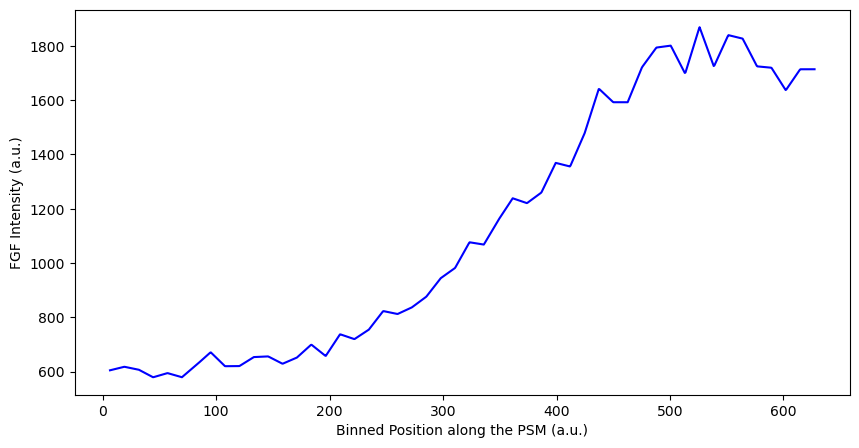

Processing image set 19/30


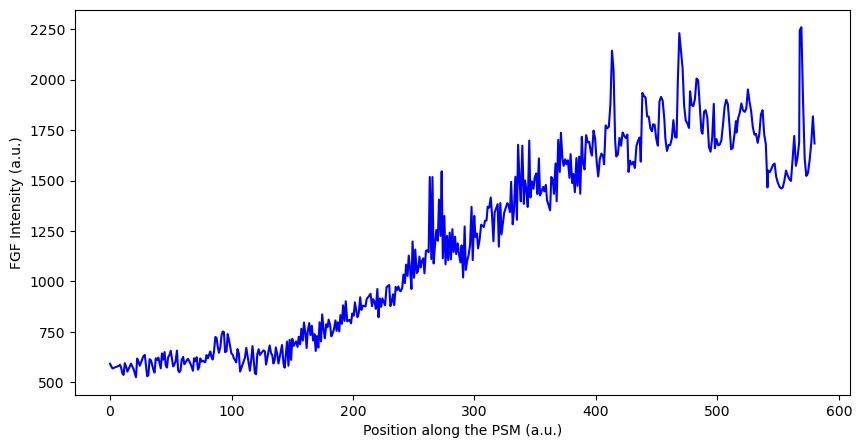

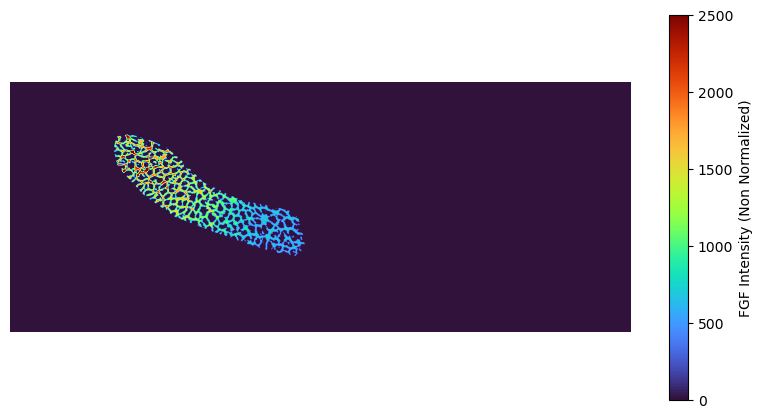

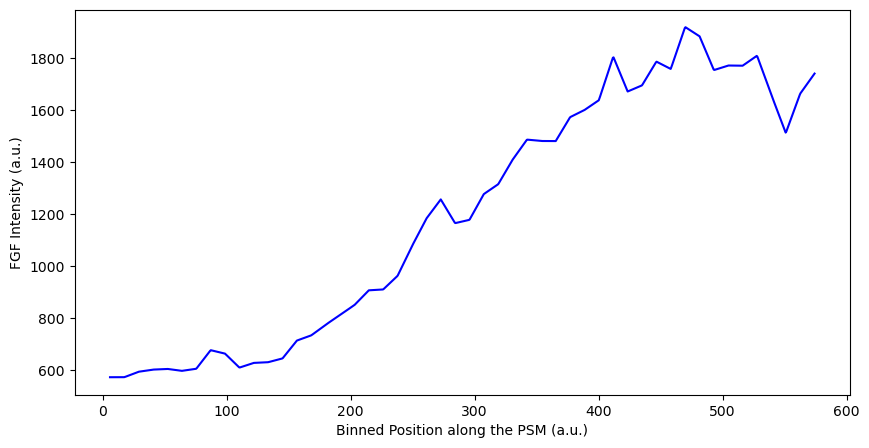

Processing image set 20/30


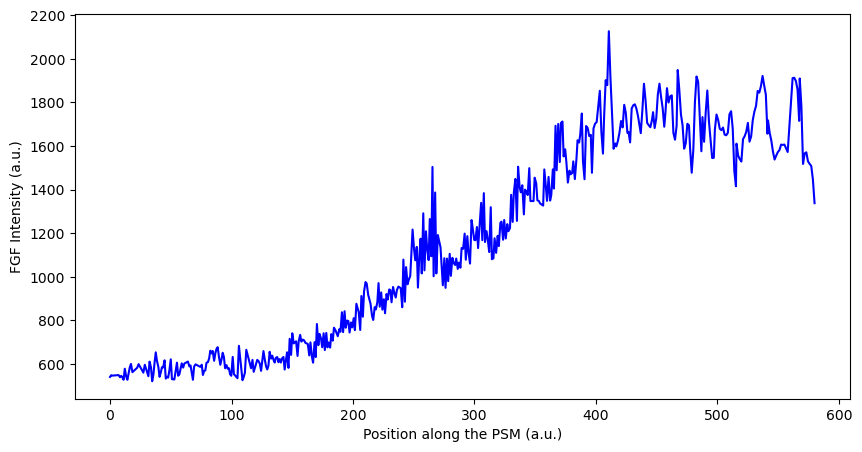

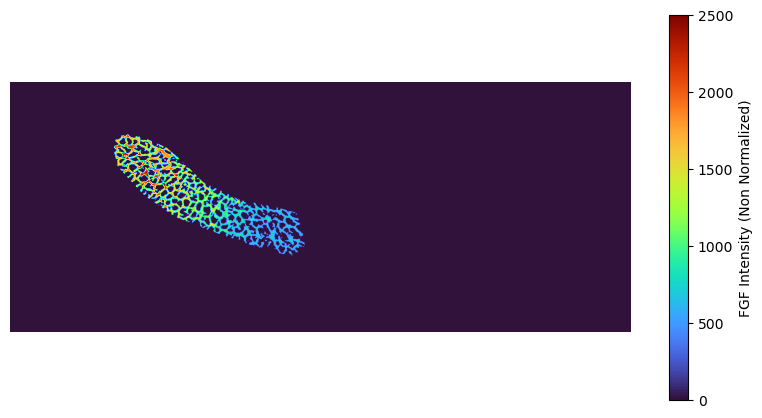

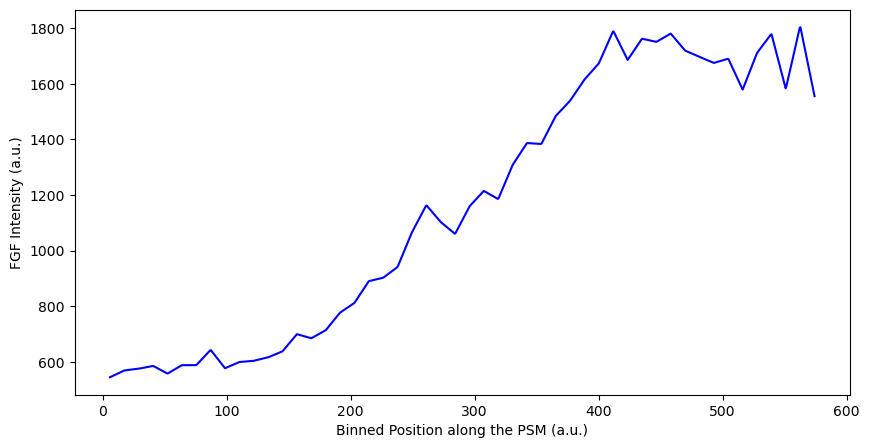

Processing image set 21/30


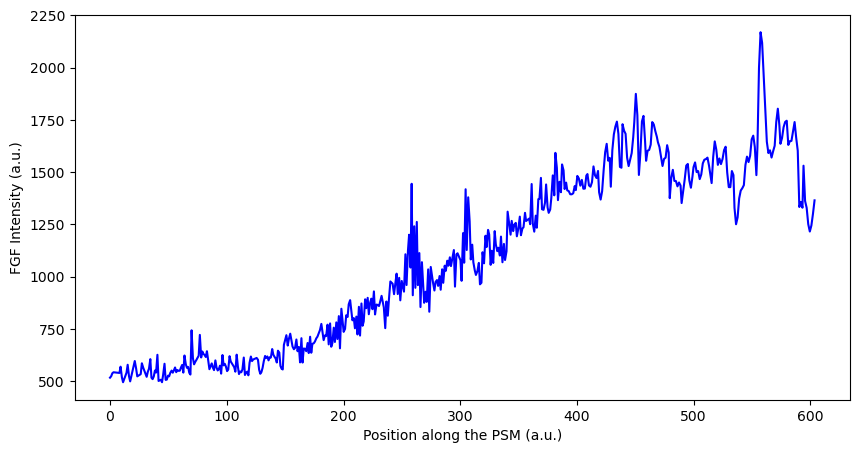

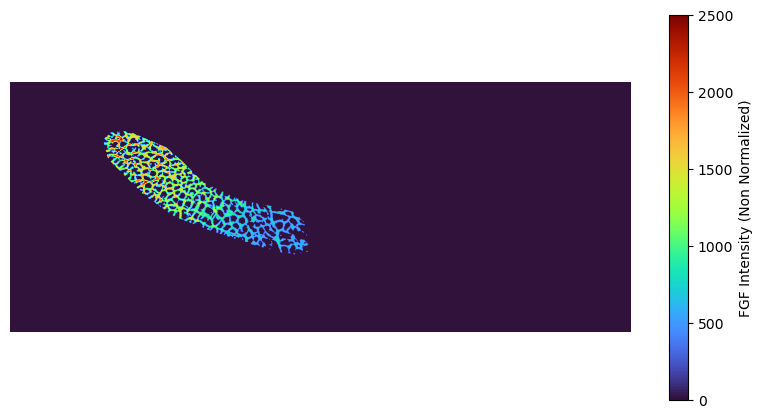

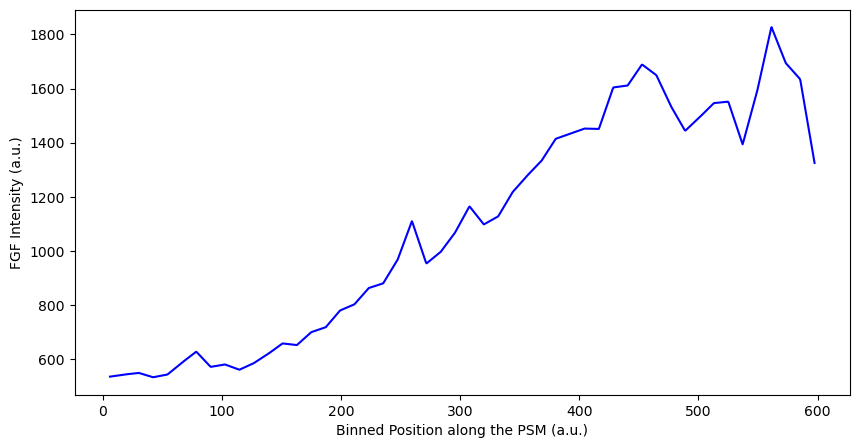

Processing image set 22/30


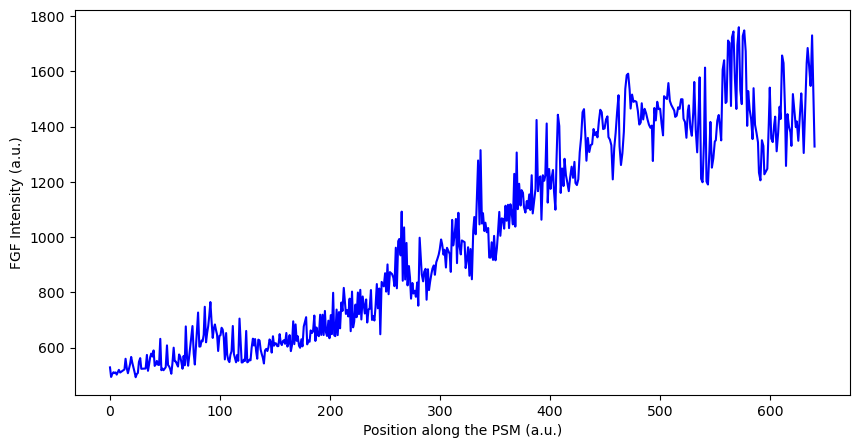

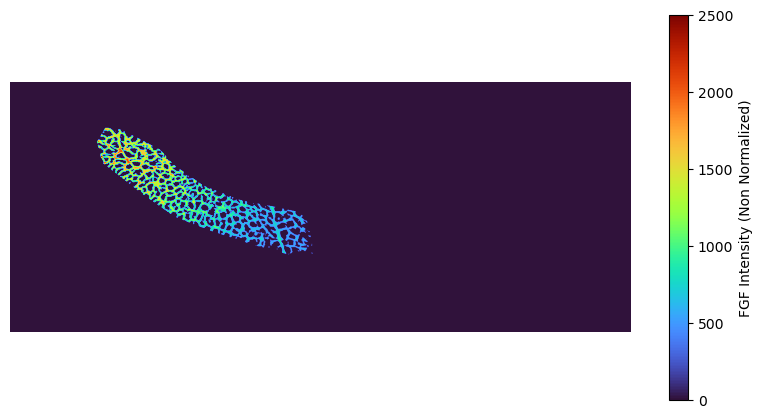

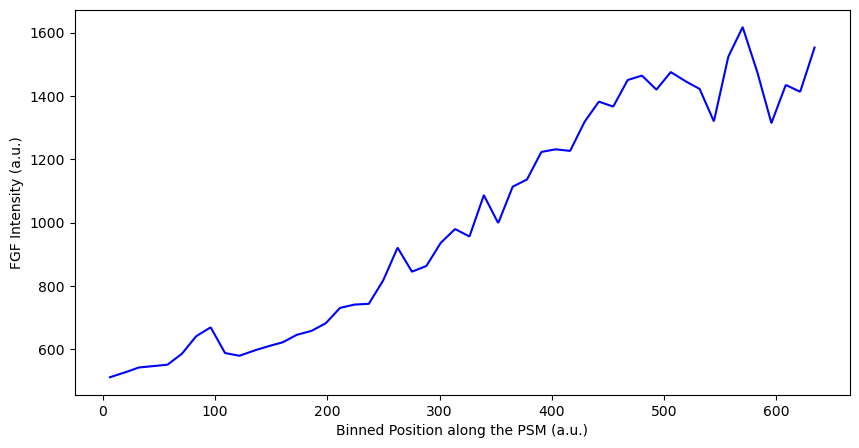

Processing image set 23/30


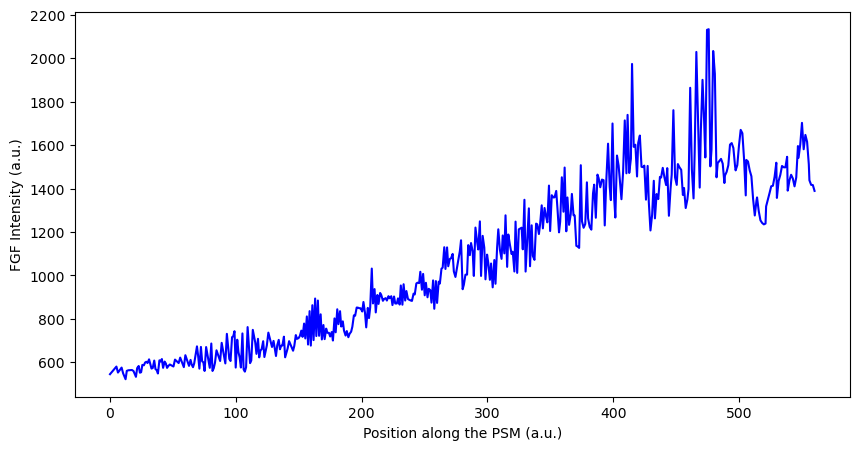

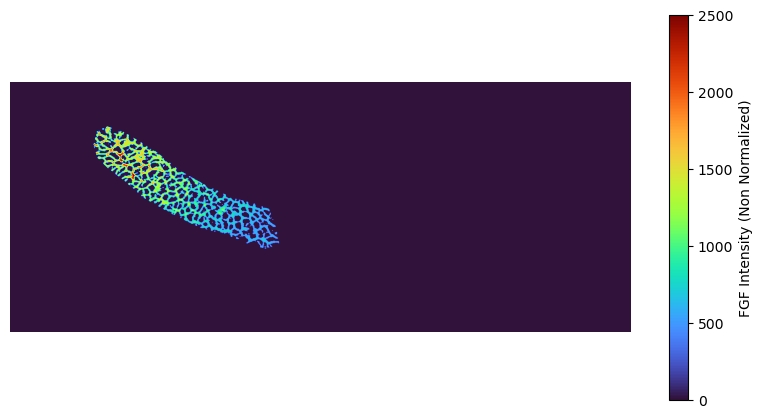

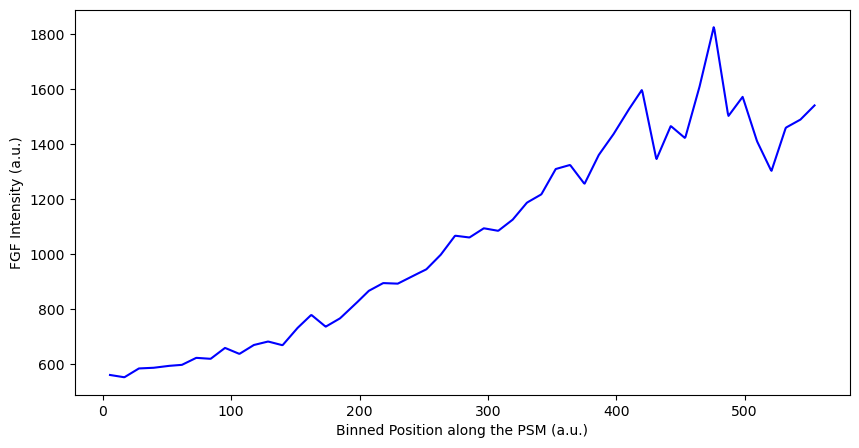

Processing image set 24/30


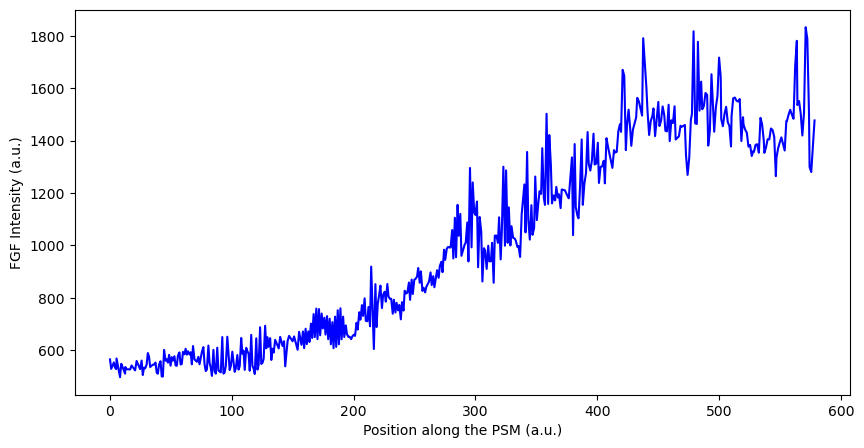

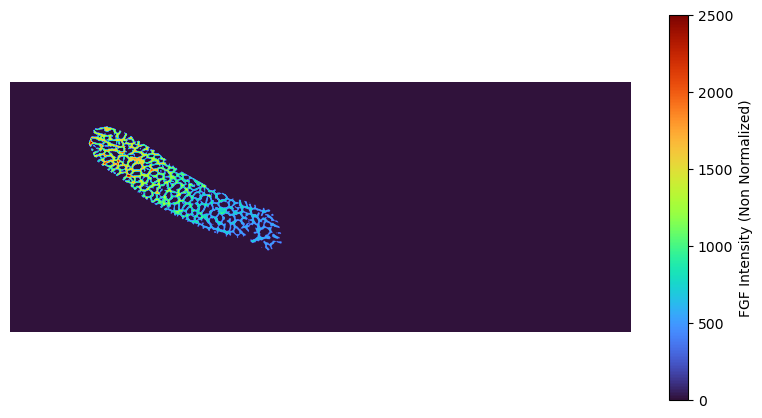

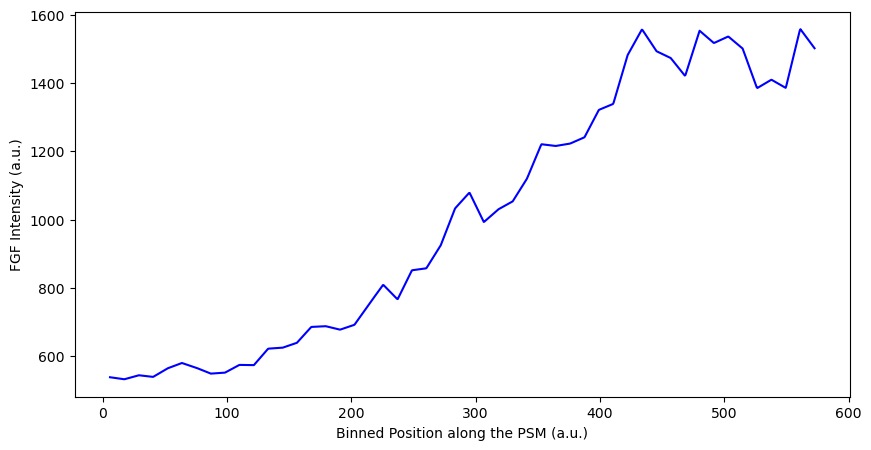

Processing image set 25/30


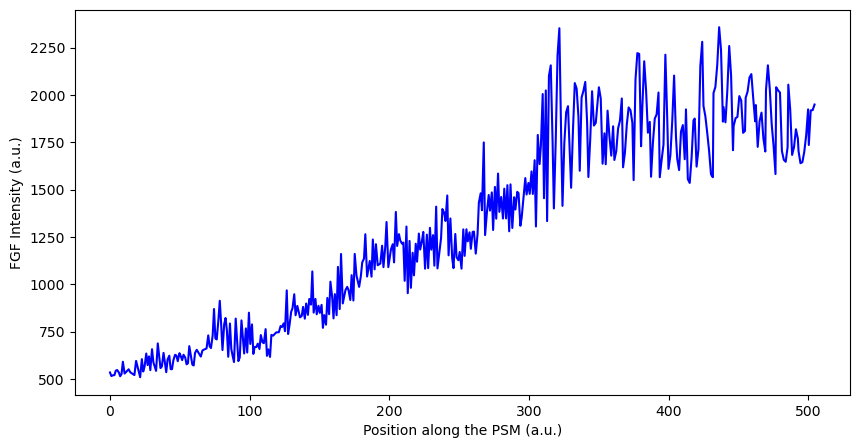

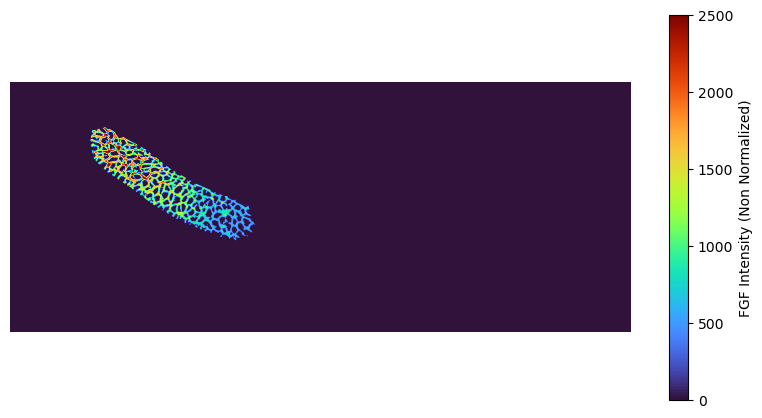

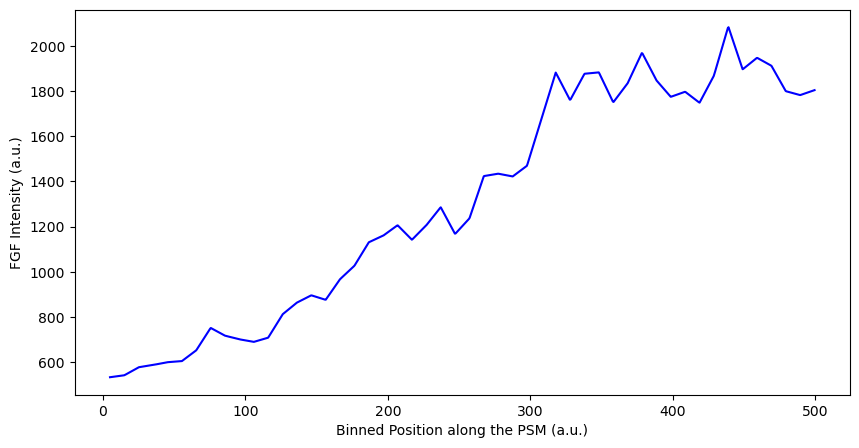

Processing image set 26/30


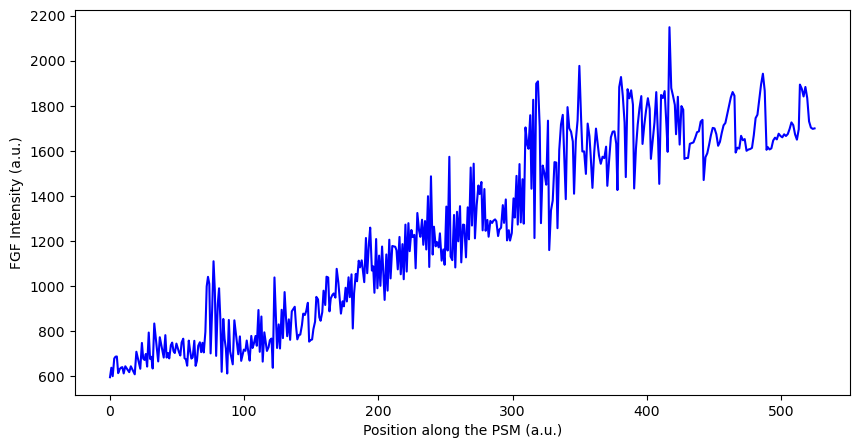

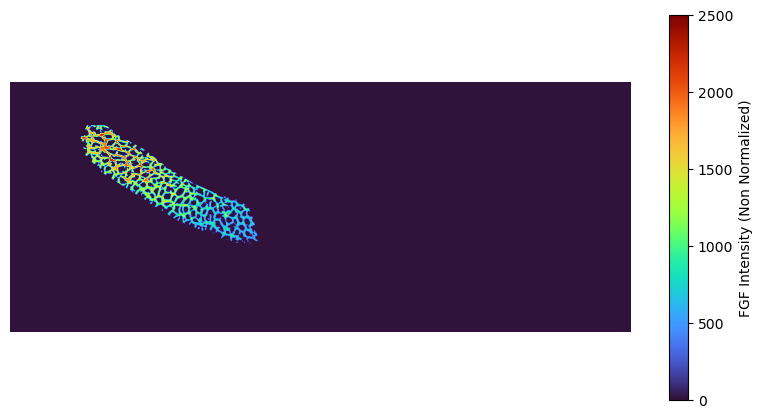

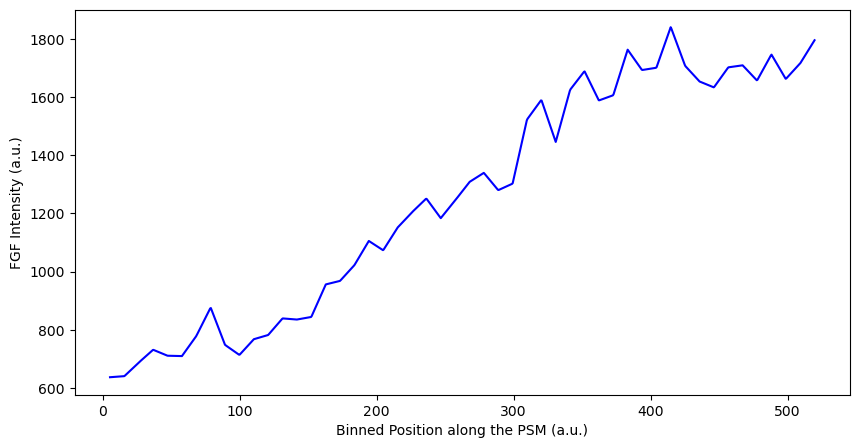

Processing image set 27/30


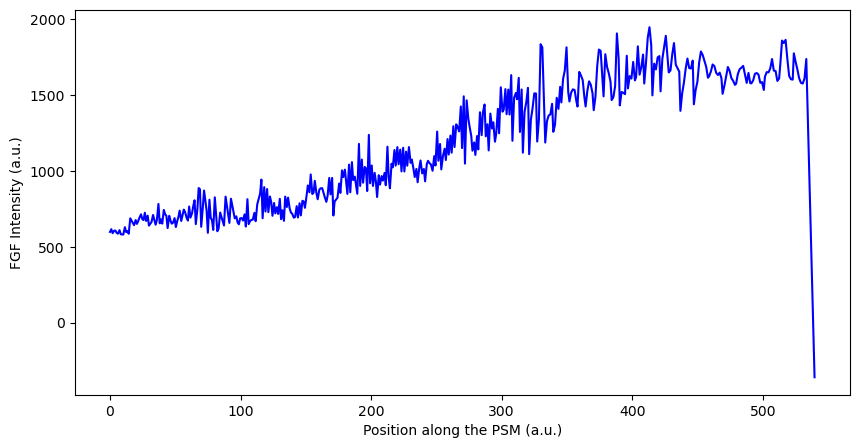

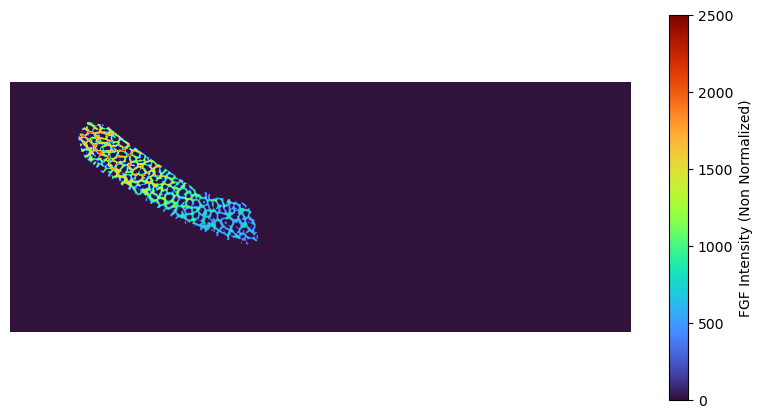

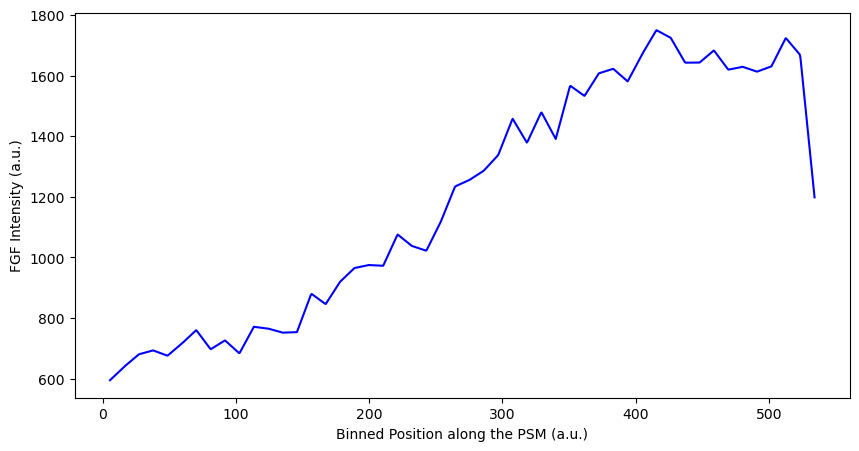

Processing image set 28/30


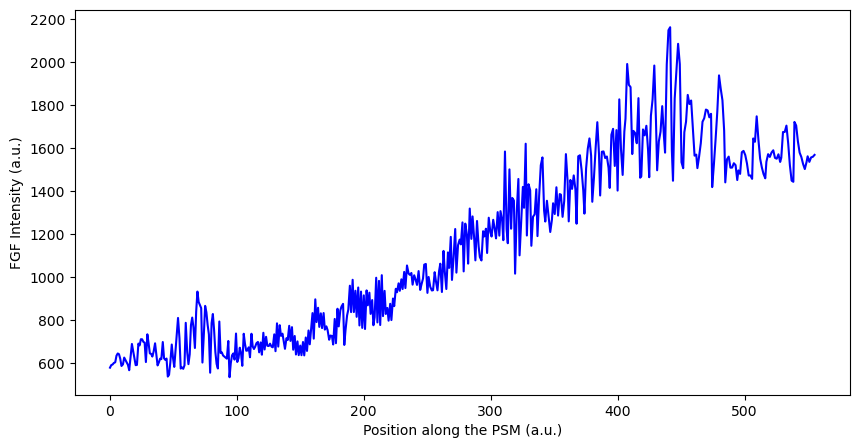

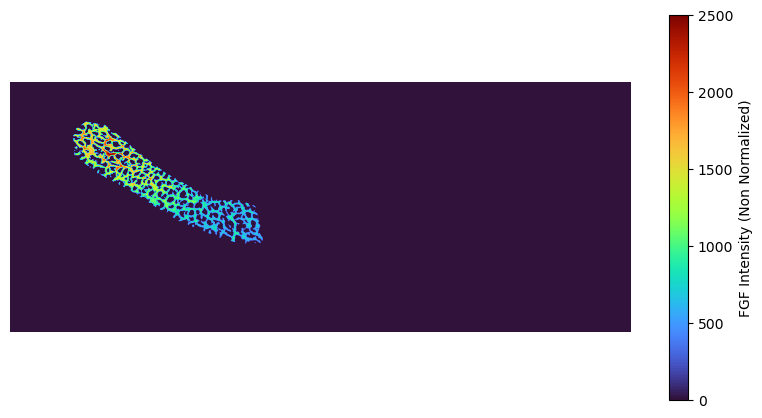

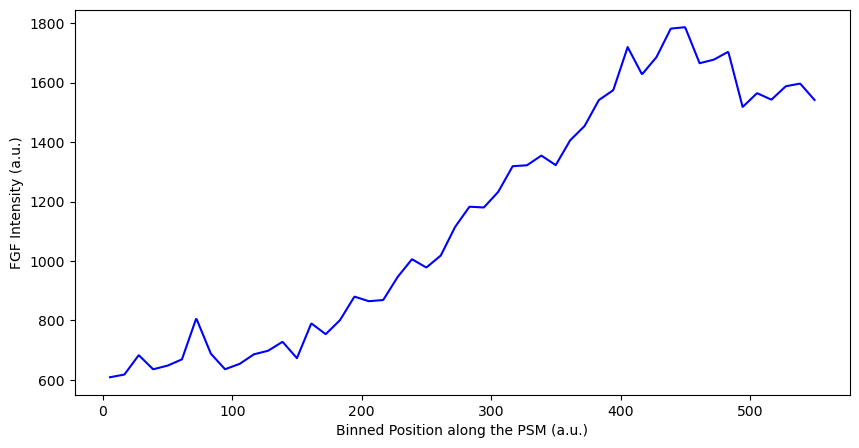

Processing image set 29/30


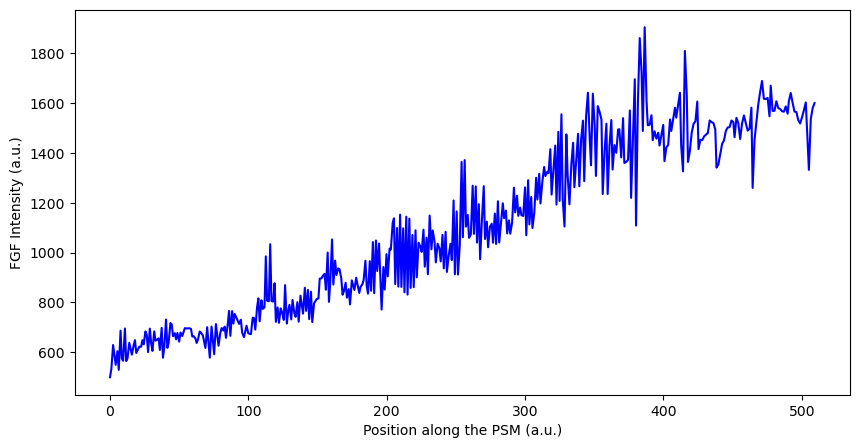

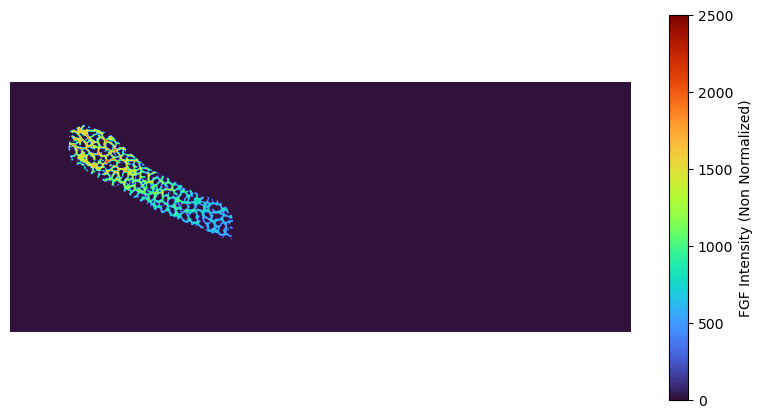

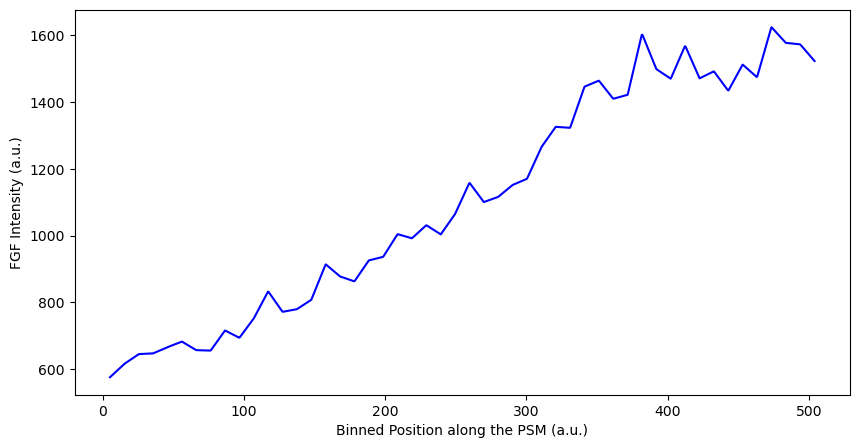

Processing image set 30/30


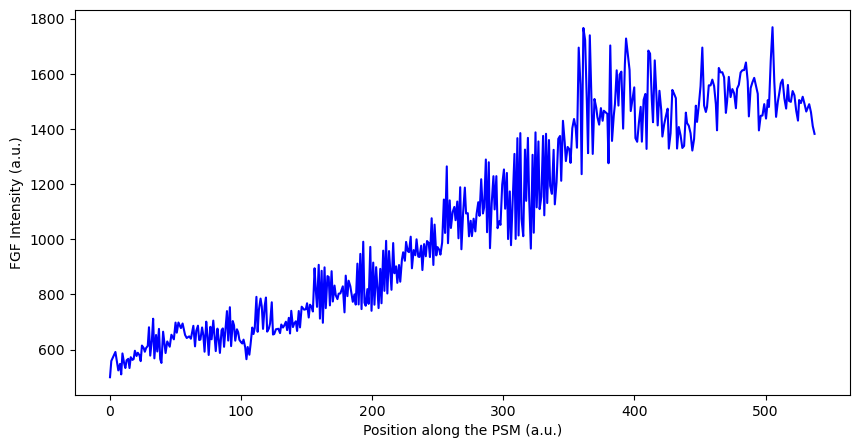

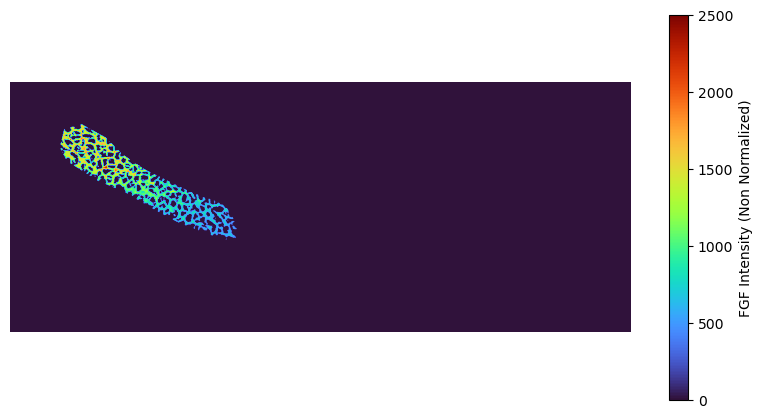

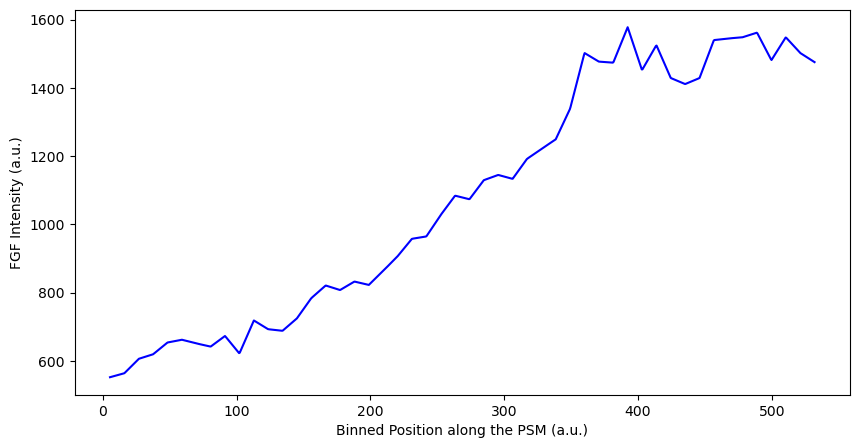

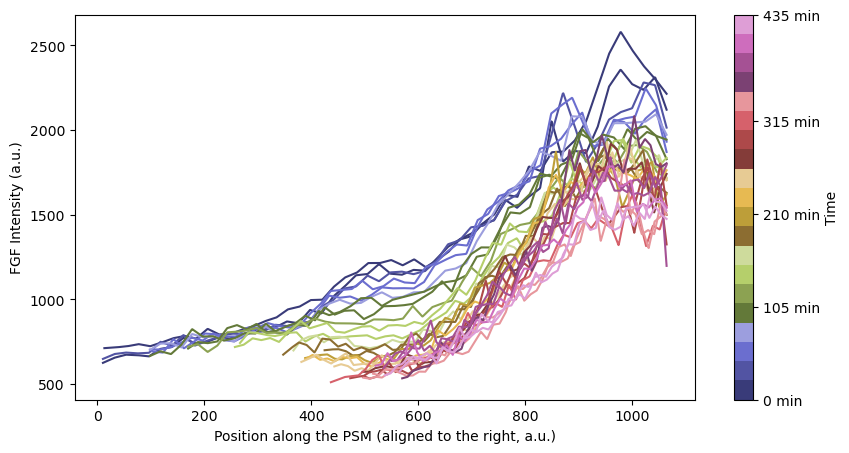

Processing complete. Results saved in E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/results/


In [28]:
#PLOT ALIGNED ON THE RIGHT
def plot_combined_binned_profiles2(all_interp_positions, all_interp_values, save_path, num_timepoints, loi_lengths):
    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.get_cmap('tab20b')  
    norm = plt.Normalize(vmin=0, vmax=num_timepoints - 1)

    max_rightmost = max(pos[-1] for pos in all_interp_positions)  # Find the rightmost endpoint

    for i, (interp_positions, interp_values) in enumerate(zip(all_interp_positions, all_interp_values)):
        shift_amount = max_rightmost - interp_positions[-1]  # Calculate how much to shift
        aligned_positions = interp_positions + shift_amount  # Apply the shift
        color = cmap(norm(i))
        ax.plot(aligned_positions, interp_values, color=color)

    ax.set_xlabel('Position along the PSM (aligned to the right, a.u.)')
    ax.set_ylabel('FGF Intensity (a.u.)')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Time')
    cbar_ticks = np.linspace(0, num_timepoints - 1, 5).astype(int)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{i * 15} min" for i in cbar_ticks])

    plt.savefig(save_path, format='tiff', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def calculate_loi_length(loi_coords):
    distances = np.sqrt(np.sum(np.diff(loi_coords, axis=0)**2, axis=1))
    return np.sum(distances)

def fgf_quantification_pipeline_multiple2(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir):
    fgf_images, fgf_masks, psm_masks, lois, dextran_images = load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir)

    all_interp_positions = []
    all_interp_values = []
    loi_lengths = []

    for i, (fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path) in enumerate(zip(fgf_images, fgf_masks, psm_masks, lois, dextran_images)):
        print(f"Processing image set {i + 1}/{len(fgf_images)}")
        
        image_results_dir = os.path.join(results_dir, f"image_set_{i + 1}")
        os.makedirs(image_results_dir, exist_ok=True)

        interp_positions, interp_values, loi_length = fgf_quantification_pipeline_with_euclidean_no_normalization2(
            fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, image_results_dir
        )

        all_interp_positions.append(interp_positions)
        all_interp_values.append(interp_values)
        loi_lengths.append(loi_length)

    combined_plot_path = os.path.join(results_dir, 'combined_binned_profiles_aligned_right.tif')
    plot_combined_binned_profiles2(all_interp_positions, all_interp_values, combined_plot_path, num_timepoints=len(fgf_images), loi_lengths=loi_lengths)
    
    print(f"Processing complete. Results saved in {results_dir}")

def fgf_quantification_pipeline_with_euclidean_no_normalization2(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path, results_dir):
    fgf, fgf_mask, psm_mask, loi, _ = load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path, dextran_path)
    fgf_psm_mask = create_combined_mask(fgf_mask, psm_mask)
    positive_pixels, fgf_intensities = find_positive_pixels(fgf_psm_mask, fgf)

    normalized_intensities = fgf_intensities.astype(np.float64)  # Nessuna normalizzazione

    loi_coords = np.column_stack(np.where(loi))
    loi_length = calculate_loi_length(loi_coords)  # Calcola la lunghezza della LOI

    nearest_loi_points = calculate_nearest_loi_points(positive_pixels, loi_coords)
    intensity_profile = calculate_intensity_profile(nearest_loi_points, normalized_intensities, loi_coords)

    rightmost_loi_point = loi_coords[np.argmax(loi_coords[:, 1])]
    distances_from_rightmost = distance.cdist([rightmost_loi_point], loi_coords, metric='euclidean').flatten()

    sorted_indices = np.argsort(distances_from_rightmost)
    sorted_distances = distances_from_rightmost[sorted_indices]
    sorted_intensity_profile = intensity_profile[sorted_indices]

    non_zero_mask = sorted_intensity_profile > 0
    interp_func = interp1d(sorted_distances[non_zero_mask], sorted_intensity_profile[non_zero_mask], bounds_error=False, fill_value="extrapolate")
    interpolated_intensities = interp_func(sorted_distances)

    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances, interpolated_intensities, c='b')
    plt.xlabel('Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    plot_path = os.path.join(results_dir, 'intensity_profile_no_normalization.svg')
    plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    filtered_fgf_image_path = os.path.join(results_dir, 'filtered_fgf_image_non_normalized.tif')
    fgf_psm_binary = fgf_psm_mask > 0
    visualize_filtered_fgf(fgf, fgf_psm_binary, filtered_fgf_image_path)

    num_bins = 50
    bin_edges = np.linspace(0, sorted_distances[-1], num_bins + 1)
    bin_indices = np.digitize(sorted_distances, bin_edges)

    binned_intensities = np.array([interpolated_intensities[bin_indices == i].mean() for i in range(1, num_bins + 1)])
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

    interp_bin_func = interp1d(bin_centers, binned_intensities, kind='linear', fill_value="extrapolate")
    interp_positions = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    interp_values = interp_bin_func(interp_positions)

    plt.figure(figsize=(10, 5))
    plt.plot(interp_positions, interp_values, c='b')
    plt.xlabel('Binned Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    binned_plot_path = os.path.join(results_dir, 'binned_plot_no_normalization.svg')
    plt.savefig(binned_plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return interp_positions, interp_values, loi_length
image_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/fgf/'
mask_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/fgf_mask/'
psm_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/tissue/'
loi_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/loi/'
dextran_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/fgf/'
results_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/results/'

fgf_quantification_pipeline_multiple2(image_dir, mask_dir, psm_dir, loi_dir, dextran_dir, results_dir)